<a href="https://colab.research.google.com/github/julandd2009/Energy_data_generation/blob/main/DPM_GANs_AidLike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Diffussion probabilistic models implementation day--ahead energy price generation

This code follows the one at https://e-dorigatti.github.io/math/deep%20learning/2023/06/25/diffusion.html

The reference paper is
@misc{ho2020denoisingdiffusionprobabilisticmodels,
      title={Denoising Diffusion Probabilistic Models},
      author={Jonathan Ho and Ajay Jain and Pieter Abbeel},
      year={2020},
      eprint={2006.11239},
      archivePrefix={arXiv},
      primaryClass={cs.LG},
      url={https://arxiv.org/abs/2006.11239},
}

Data sources:
https://transparency.entsoe.eu/content/static_content/Static%20content/knowledge%20base/SFTP%20guide.html

In this notebook we use the file Aggregated_ENTSOe_2015_2024_FRN.csv


#Mount Drive

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

read_dir = "/content/drive/My Drive/Colab Notebooks/A5_GANS/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mounted at /content/drive


# DEPENDENCIES

In [3]:
pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 102.0 MB/s eta 0:00:00


In [4]:
import gurobipy as gp
from gurobipy import GRB

license_path = read_dir+'gurobi.lic'

os.environ['GRB_LICENSE_FILE'] = license_path

Myenv = gp.Env()
Myenv.setParam('OutputFlag', 0)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2668660
Academic license 2668660 - for non-commercial use only - registered to ju___@ensae.fr


In [5]:
# DEPENDENCIES
from typing import Callable, Any, List, Tuple
import pandas as pd
import seaborn as sns
import itertools
import calendar
import numpy as np
np.random.seed(42)
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import statsmodels.api as sm
from scipy.stats import shapiro
from torch.utils.data import DataLoader, TensorDataset

from scipy import stats
from scipy.stats import ks_2samp
from scipy.stats import wasserstein_distance_nd
#App2
from scipy.optimize import curve_fit
from scipy.stats import t
from sklearn.manifold import TSNE

import time
import pickle

Hour_values = ['00:00', '01:00', '02:00', '03:00',
       '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00',
       '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00',
       '20:00', '21:00', '22:00', '23:00']

#DDPM class

In [6]:
class mean_model(nn.Module):
    def __init__(self, target_dim, label_dim, t_label_dim, output_dim):
        super(mean_model, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(target_dim + label_dim + t_label_dim + 1, 256),  # + 1 is the time component in the difusion
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    def forward(self, x):
        return self.model(x)

class DDPM:
    def __init__(
        self,
        name: str,
        model_cls: Callable[..., object],
        target_cols: List[str],
        label_cols: List[str],
        t_label_cols: List[str],
        ab_t: np.ndarray,
        a_t: np.ndarray,
        beta: np.ndarray,
    ):
        self.name        = name
        self.target_cols = target_cols
        self.label_cols  = label_cols
        self.t_label_cols= t_label_cols
        self.target_dim  = len(self.target_cols)
        self.label_dim   = len(self.label_cols)
        self.t_label_dim = len(self.t_label_cols)
        self.output_dim  = self.target_dim
        self.ab_t        = ab_t
        self.a_t         = a_t
        self.beta        = beta
        self.time_steps  = self.ab_t.shape[0]

        self.model = model_cls(
            target_dim   = self.target_dim,
            label_dim    = self.label_dim,
            t_label_dim  = self.t_label_dim,
            output_dim   = self.output_dim,
        )

        self.trainable_params_count = self.count_trainable_parameters()

    def __repr__(self):
        return f"<DDPM {self.name}>"

    def count_trainable_parameters(self,):
        return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    def train(
        self,
        dataset: torch.utils.data.DataLoader,
        epochs: int,
        lr: float = 1e-2,
        weight_decay: float = 1e-6,
        early_stop_threshold: float = 1e-2,
        early_stop_frac: float = 0.9,
        ):

        optim = torch.optim.AdamW(
            self.model.parameters(),
            lr=lr,
            weight_decay=weight_decay
        )
        self.model.train()

        loss_history = []
        early_stop_epoch = int(early_stop_frac * epochs)

        start_time = time.time()
        for epoch in range(epochs):
            epoch_loss = 0.0
            for batch in dataset:
                x = batch[0]
                xt = x[:, :self.target_dim]
                x_label = x[:, self.target_dim:]

                # sample noise and times
                noise = torch.randn_like(xt)
                t = torch.randint(1, self.time_steps, (x.shape[0],))

                # perturb
                scale = self.ab_t[t].sqrt().unsqueeze(1)
                xt_pert = scale * xt + (1 - self.ab_t[t]).unsqueeze(1) * noise

                # build input: [perturbed, labels, time-fraction]
                t_frac = (t.float() / self.time_steps).unsqueeze(1)
                xin = torch.cat([xt_pert, x_label, t_frac], dim=1)

                # forward + loss
                optim.zero_grad()
                pred_noise = self.model(xin)
                loss = F.mse_loss(pred_noise, noise)
                loss.backward()
                optim.step()

                epoch_loss += loss.item()

            # bookkeeping & print
            avg_loss = epoch_loss / len(dataset)
            loss_history.append(avg_loss)

            elapsed = int(time.time() - start_time)
            h, rem = divmod(elapsed, 3600)
            m, s   = divmod(rem, 60)
            pct = (epoch + 1) / epochs * 100
            print(
                f"\r[{self.name}] "
                f"Epoch {epoch+1}/{epochs} "
                f"Loss={avg_loss:.4f} "
                f"{pct:.0f}% "
                f"Elapsed={h:02}:{m:02}:{s:02}",
                end=""
            )

            # early stopping
            if epoch >= early_stop_epoch and avg_loss < early_stop_threshold:
                print("\nEarly stopping criteria met.")
                break

        print("\nTraining complete ✅")
        return loss_history

    def diffuse(
        self,
        data: torch.Tensor
    ):
        """
        Perform the forward diffusion process (q):
        returns (q_distributions, noisy_samples, original_targets).
        """
        q_dists: List[torch.distributions.Normal] = []
        samples: List[torch.Tensor] = []

        # start from x0 (clean data)
        xt = data[:, :self.target_dim]
        samples.append(xt)

        for t in range(self.time_steps):
            q = torch.distributions.Normal(torch.sqrt(1 - self.beta[t]) * xt,
                                           torch.sqrt(self.beta[t]) * torch.ones_like(xt)
            )
            xt = q.sample()
            q_dists.append(q)
            samples.append(xt)

        # return the list of q's, the list of samples, and the original x0
        return q_dists, samples, data[:, :self.target_dim]

    def check_normality(
        self,
        samples: List[torch.Tensor],
        alpha: float = 0.05
    ):
        """
        Run a Shapiro–Wilk test on the final timestep samples for each target dimension.
        Prints a warning if normality is rejected at level alpha.
        """
        final = samples[-1].numpy()
        for dim in range(self.target_dim):
            stat, p_value = shapiro(final[:, dim])
            if p_value <= alpha:
                print(f"⚠️ Dimension {dim}: Reject normality")

    def save(self, path: str, loss_history: List[float]):
        """
        Save the model’s configuration, weights, and loss history to `path`.
        """
        payload = {
            'name':            self.name,
            'target_cols':     self.target_cols,
            'label_cols':      self.label_cols,
            't_label_cols':    self.t_label_cols,
            'ab_t':            self.ab_t,
            'a_t':             self.a_t,
            'beta':            self.beta,
            'model_state':     self.model.state_dict(),
            'loss_history':    loss_history,
        }
        torch.save(payload, path)

    @classmethod
    def load(cls, path: str, model_cls: Callable[..., object]):
        """
        Load everything from `path`, returning (ddpm_instance, loss_history).
        You must pass in the same `model_cls` used originally.
        """
        payload = torch.load(path)

        # Recreate the DDPM instance
        inst = cls(
            name          = payload['name'],
            model_cls     = model_cls,
            target_cols   = payload['target_cols'],
            label_cols    = payload['label_cols'],
            t_label_cols  = payload['t_label_cols'],
            ab_t          = payload['ab_t'],
            a_t           = payload['a_t'],
            beta          = payload['beta'],
        )

        # Load weights
        inst.model.load_state_dict(payload['model_state'])
        inst.model.eval()

        # Extract loss history
        loss_history = payload.get('loss_history', [])

        return inst, loss_history

    def sample_reverse(
        self,
        labels_gen: torch.Tensor,
        factor: float = 1/3,
        ):
        batch_size = labels_gen.size(0)

        x_noise = torch.randn(batch_size, self.target_dim)
        xt = torch.cat([x_noise, labels_gen], dim=1)
        history = [xt]

        for t in range(self.time_steps-1, 0, -1):
            t_frac = (t / self.time_steps) * torch.ones(batch_size, 1)
            inp = torch.cat([xt, t_frac], dim=1)
            pred_noise = self.model(inp)

            x_part = xt[:, :self.target_dim]
            coef1  = (1 - self.a_t[t]) / (1 - self.ab_t[t]).sqrt()
            x_recon = (x_part - pred_noise * coef1) / self.a_t[t].sqrt()

            z = torch.randn_like(x_recon)
            x_part = x_recon + z * (factor * self.beta[t]).sqrt()

            xt = torch.cat([x_part, labels_gen], dim=1)
            history.append(xt)

        return history

    def generate_fake_data(
        self,
        labels_gen: torch.Tensor,
        testData1: pd.DataFrame,
        ):
        sample = torch.stack(self.sample_reverse(labels_gen))
        sample = self.populate_gen_data(testData1, sample, self.target_cols,)
        return sample

    def populate_gen_data(
        self,
        labels_data: pd.DataFrame,
        samples: List[torch.Tensor],
        columns: List[str]
        ):
        df = labels_data.copy()
        final = samples[-1].detach().numpy()
        for j, col in enumerate(columns):
            df[col] = final[:, j]
        return df

#GANS class

In [7]:
#Unique to GANS
# Hyperparameters
latent_dim = 100          # Size of random noise vector
batch_size_GANS = 128

class Generator(nn.Module):
    def __init__(self, latent_dim, target_dim, label_dim, t_label_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + label_dim + t_label_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, target_dim),
            nn.Tanh(),  # outputs in [-1,1]
        )

    def forward(self, z):
        return self.model(z) * 10  # scale to [-10, 10]


class Discriminator(nn.Module):
    def __init__(self, target_dim, label_dim, t_label_dim):
        super(Discriminator, self).__init__()
        self.target_dim = target_dim
        self.model = nn.Sequential(
            nn.Linear(target_dim + label_dim + t_label_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid(),  # probability output
        )

    def forward(self, x):
        return self.model(x)


class Critic(nn.Module):
    def __init__(self, target_dim, label_dim, t_label_dim):
        super(Critic, self).__init__()
        self.target_dim = target_dim
        self.model = nn.Sequential(
            nn.Linear(target_dim + label_dim + t_label_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.model(x)

# --------------------------------------------
# Shared (Between GAN and WGAN) Utility Function
# --------------------------------------------

def random_label_gen(n_samples, target_dim, label_dim, t_label_dim, real_data):
    """
    Selects n_samples random rows from `real_data` and returns
    their label/t_label vectors (i.e., columns [target_dim : target_dim + label_dim + t_label_dim]).
    """
    indices = np.random.RandomState(seed=42).choice(real_data.shape[0], size=n_samples, replace=False)
    X_real = real_data[indices]
    # slice out the label + t_label portion
    return X_real[:, target_dim : target_dim + label_dim + t_label_dim]

In [8]:
# --------------------------------------------
# GAN Class
# --------------------------------------------
class GAN:
    def __init__(
        self,
        name: str,
        latent_dim: int,
        target_cols: List[str],
        label_cols: List[str],
        t_label_cols: List[str],
        lr: float = 2e-4,
        ):
        """
        Initializes a standard GAN with:
        - latent_dim: dimension of noise vector
        - target_dim, label_dim, t_label_dim: dimensions for data + labels
        - lr: learning rate for both G and D
        """
        self.name = name
        self.latent_dim = latent_dim
        self.target_cols = target_cols
        self.label_cols  = label_cols
        self.t_label_cols= t_label_cols
        self.target_dim = len(self.target_cols)
        self.label_dim = len(self.label_cols)
        self.t_label_dim = len(self.t_label_cols)

        # Instantiate networks
        self.generator = Generator(self.latent_dim, self.target_dim, self.label_dim, self.t_label_dim)
        self.discriminator = Discriminator(self.target_dim, self.label_dim, self.t_label_dim)

        # Optimizers
        self.optim_g = optim.Adam(self.generator.parameters(), lr=lr)
        self.optim_d = optim.Adam(self.discriminator.parameters(), lr=lr)

    @staticmethod
    def discriminator_loss(real_output: torch.Tensor, fake_output: torch.Tensor):
        real_loss = -torch.mean(torch.log(real_output + 1e-12))
        fake_loss = -torch.mean(torch.log(1 - fake_output + 1e-12))
        return (real_loss + fake_loss) / 2

    @staticmethod
    def generator_loss(fake_output: torch.Tensor):
        return -torch.mean(torch.log(fake_output + 1e-12))

    def train_discriminator(
        self,
        real_data: torch.Tensor,
        fake_data: torch.Tensor,
        ):
        self.optim_d.zero_grad()
        real_output = self.discriminator(real_data)
        fake_output = self.discriminator(fake_data)
        loss_d = self.discriminator_loss(real_output, fake_output)
        loss_d.backward()
        self.optim_d.step()
        return loss_d

    def train_generator(
        self,
        noise: torch.Tensor,
        random_label: torch.Tensor,
        ):
        self.optim_g.zero_grad()
        # generate fake target from noise + labels
        fake_data = self.generator(torch.cat([noise, random_label], axis=1))
        fake_data = torch.cat([fake_data, random_label], axis=1)
        fake_output = self.discriminator(fake_data)
        loss_g = self.generator_loss(fake_output)
        loss_g.backward()
        self.optim_g.step()
        return loss_g

    def summarize_performance_discriminator(
        self,
        Training_dataset_torch: torch.Tensor,
        n_samples: int = 100,
        ):
        # Sample real
        indices = np.random.RandomState(seed=42).choice(Training_dataset_torch.shape[0], size=n_samples, replace=False)
        X_real = Training_dataset_torch[indices]
        y_real = np.ones((n_samples, 1))

        # Generate fake
        noise = torch.randn(n_samples, self.latent_dim)
        random_label = random_label_gen(
            n_samples,
            self.target_dim,
            self.label_dim,
            self.t_label_dim,
            Training_dataset_torch,
        )
        X_fake = self.generator(torch.cat([noise, random_label], axis=1))
        X_fake = torch.cat((X_fake, random_label), axis=1)
        y_fake = np.zeros((n_samples, 1), dtype=int)

        # Evaluate discriminator on real samples
        real_output = self.discriminator(X_real.clone().detach().float())
        real_accuracy = np.mean((real_output.clone().detach().numpy() > 0.5).astype(int) == y_real)

        # Evaluate discriminator on fake samples
        fake_output = self.discriminator(X_fake.detach())
        fake_accuracy = np.mean((fake_output.clone().detach().numpy() <= 0.5).astype(int) == y_fake)  # Convert fake_output to NumPy array for comparison

        return real_accuracy, fake_accuracy

    def train(
        self,
        Training_dataset_torch: torch.Tensor,
        Training_dataset_DataLoader: torch.utils.data.DataLoader,
        epochs: int,
        n_feedback_every: int = 0,
        n_feedback_samples: int = 100,
        ):
        g_losses , d_losses = [], []
        real_accuracy_v, fake_accuracy_v = [], []
        real_accuracy, fake_accuracy = 0.0, 0.0

        start_time = time.time()

        for epoch in range(epochs):
            for batch in Training_dataset_DataLoader:
                real_batch = batch[0]
                batch_size = real_batch.size(0)

                # Generate random noise for fake data
                noise = torch.randn(batch_size, self.latent_dim)
                random_label = random_label_gen(
                    batch_size,
                    self.target_dim,
                    self.label_dim,
                    self.t_label_dim,
                    Training_dataset_torch,
                )
                # generate fake_data
                fake_data = self.generator(torch.cat((noise, random_label), axis=1))
                fake_data = torch.cat((fake_data, random_label), axis=1)

                # Train Discriminator
                loss_d = self.train_discriminator(real_batch, fake_data.detach())
                d_losses.append(loss_d.item())

                # Train Generator
                noise = torch.randn(batch_size, self.latent_dim)
                random_label = random_label_gen(
                    batch_size,
                    self.target_dim,
                    self.label_dim,
                    self.t_label_dim,
                    Training_dataset_torch,
                )
                loss_g = self.train_generator(noise, random_label)
                g_losses.append(loss_g.item())

            # Calculate elapsed time
            elapsed_time = int(time.time() - start_time)
            hours, remainder = divmod(elapsed_time, 3600)
            minutes, seconds = divmod(remainder, 60)
            elapsed_time_str = f"{hours:02}:{minutes:02}:{seconds:02}"  # Format hh:mm:ss

            # Calculate percentage completion
            percentage = (epoch + 1) / epochs * 100
            if n_feedback_every > 0 and ((epoch + 1) % n_feedback_every == 0):
                real_accuracy, fake_accuracy = self.summarize_performance_discriminator(Training_dataset_torch, n_feedback_samples)
                real_accuracy_v.append(real_accuracy)
                fake_accuracy_v.append(fake_accuracy)
                print(
                    f"\r[{self.name}] Epoch {epoch+1}/{epochs} "
                    f"Loss G={loss_g.item():.4f}, Loss D={loss_d.item():.4f} "
                    f"{percentage:.0f}% "
                    f"Acc Real={real_accuracy*100:.0f}%, Acc Fake={fake_accuracy*100:.0f}% "
                    f"Elapsed={hours:02}:{minutes:02}:{seconds:02}",
                    end=""
                )
            else:
                print(
                    f"\r[{self.name}] Epoch {epoch+1}/{epochs} "
                    f"Loss G={loss_g.item():.4f}, Loss D={loss_d.item():.4f} "
                    f"{percentage:.0f}% "
                    f"Elapsed={hours:02}:{minutes:02}:{seconds:02}",
                    end=""
                )

        print("\nGAN training complete ✅")
        return g_losses, d_losses, real_accuracy_v, fake_accuracy_v

    # --------------------------------------------
    # Save & Load Methods
    # --------------------------------------------
    def save(
        self,
        save_dir: str,
        idgen: str,
        iddisc: str,
        idg_losses: str,
        idd_losses: str,
        idreal_accuracy_v: str,
        idfake_accuracy_v: str,
        g_losses: list,
        d_losses: list,
        real_accuracy_v: list,
        fake_accuracy_v: list,
    ):
        """
        Saves generator, discriminator, and all history vectors to `save_dir`.
        Filenames are constructed as <id>.<ext>:
          - Generator  => <idgen>.pth
          - Discriminator => <iddisc>.pth
          - g_losses   => <idg_losses>.txt
          - d_losses   => <idd_losses>.txt
          - real_accuracy_v => <idreal_accuracy_v>.txt
          - fake_accuracy_v => <idfake_accuracy_v>.txt
        """
        # Ensure directory exists
        os.makedirs(save_dir, exist_ok=True)

        # 1) Save models
        generator_model_save_path     = os.path.join(save_dir, idgen + ".pth")
        discriminator_model_save_path = os.path.join(save_dir, iddisc + ".pth")
        torch.save(self.generator, generator_model_save_path)
        torch.save(self.discriminator, discriminator_model_save_path)

        # 2) Save generator losses
        path = os.path.join(save_dir, idg_losses + ".txt")
        with open(path, "w") as f:
            f.write(", ".join(map(str, g_losses)))

        # 3) Save discriminator losses
        path = os.path.join(save_dir, idd_losses + ".txt")
        with open(path, "w") as f:
            f.write(", ".join(map(str, d_losses)))

        # 4) Save real accuracy history
        path = os.path.join(save_dir, idreal_accuracy_v + ".txt")
        with open(path, "w") as f:
            f.write(", ".join(map(str, real_accuracy_v)))

        # 5) Save fake accuracy history
        path = os.path.join(save_dir, idfake_accuracy_v + ".txt")
        with open(path, "w") as f:
            f.write(", ".join(map(str, fake_accuracy_v)))

    @staticmethod
    def load(
        idgen: str,
        iddisc: str,
        idg_losses: str,
        idd_losses: str,
        idreal_accuracy_v: str,
        idfake_accuracy_v: str,
        save_dir: str,
    ):
        """
        Loads a saved GAN’s generator, discriminator and all histories from `save_dir`.
        Returns:
          generator_model, discriminator_model, g_losses_list, d_losses_list, real_accuracy_list, fake_accuracy_list
        (as numpy/python lists).
        """
        # Paths for saved models
        generator_model_save_path     = os.path.join(save_dir, idgen + ".pth")
        discriminator_model_save_path = os.path.join(save_dir, iddisc + ".pth")

        # Paths for history files
        g_losses_path            = os.path.join(save_dir, idg_losses + ".txt")
        d_losses_path            = os.path.join(save_dir, idd_losses + ".txt")
        real_acc_path            = os.path.join(save_dir, idreal_accuracy_v + ".txt")
        fake_acc_path            = os.path.join(save_dir, idfake_accuracy_v + ".txt")

        # 1) Load models
        generator_model     = torch.load(generator_model_save_path, weights_only = False)
        discriminator_model = torch.load(discriminator_model_save_path, weights_only = False)

        generator_model.eval()
        discriminator_model.eval()

        # 2) Load histories
        with open(g_losses_path, "r") as f:
            g_losses_list = list(map(float, f.read().split(", ")))
        with open(d_losses_path, "r") as f:
            d_losses_list = list(map(float, f.read().split(", ")))
        with open(real_acc_path, "r") as f:
            real_accuracy_list = list(map(float, f.read().split(", ")))
        with open(fake_acc_path, "r") as f:
            fake_accuracy_list = list(map(float, f.read().split(", ")))

        return generator_model, discriminator_model, g_losses_list, d_losses_list, real_accuracy_list, fake_accuracy_list

    # --------------------------------------------
    # Fake-Data Generation & Population Methods
    # --------------------------------------------
    def generate_fake_data(
        self,
        labels_gen: torch.Tensor,
        Data: pd.DataFrame,
        ):
        """
        Given a batch of `labels_gen` (shape: [batch_size, label_dim + t_label_dim]),
        samples `noise` of shape [batch_size, latent_dim], passes through self.generator,
        concatenates labels onto generated target, and returns a NumPy array of shape
        [batch_size, target_dim + label_dim + t_label_dim].
        """
        sample_size = labels_gen.shape[0]
        noise = torch.randn(sample_size, self.latent_dim)
        fake_target = self.generator(torch.cat((noise, labels_gen), dim=1))
        fake_data = torch.cat((fake_target, labels_gen), dim=1)

        fake_data = fake_data.detach().numpy()
        fake_data = pd.DataFrame(fake_data, columns=self.target_cols+self.label_cols+self.t_label_cols)

        fake_data = self.populate_gen_data(Data, fake_data, self.target_cols)
        return fake_data

    @staticmethod
    def populate_gen_data(
        labels_data: "pd.DataFrame",
        samps: "pd.DataFrame",
        target_cols: list
        ):
        """
        Given a `labels_data` DataFrame and a DataFrame `samps` that already contains
        generated target columns indexed by the same column names as in `target_cols`,
        overwrite/add those columns in labels_data with samps[target_cols] and return.
        (Exactly the same as your standalone function.)
        """
        labels_gen_data = labels_data.copy()
        for col in target_cols:
            labels_gen_data[col] = samps[col].values
        return labels_gen_data

#Data Set handling class

In [9]:
class DataProcessor:
    """
    Loads raw data and computes all features (deseasonalization, scarcity shift,
    Price/LastUnit, etc.), storing intermediate models and timestamps.
    """
    def __init__(self, read_dir: str, date_col: str, hour_cols: List[str], years_list: List[int]):
        self.read_dir         = read_dir
        self.date_col         = date_col
        self.hour_cols        = hour_cols
        self.years_list       = years_list
        # placeholders for deseason outputs
        self.deseason_models = {}
        self.deseason_t0     = None

    def load_raw(self):
        """
        Load the raw CSV data, parse dates, and drop unnecessary columns.
        """
        df = pd.read_csv(os.path.join(self.read_dir, 'data.csv'))
        df[self.date_col] = pd.to_datetime(df[self.date_col])
        # drop MapCode if present
        df.drop(columns=['MapCode'], errors='ignore', inplace=True)
        return df

    def deseasonalize(
        self,
        df: pd.DataFrame,
        cols: List[str],
        period: int = 365,
        harmonics: int = 3,
        ):
        """
        Fit Fourier-based seasonal models on specified cols and subtract seasonality.
        Stores fitted models and reference t0.
        """
        df = df.copy()
        df.sort_values(self.date_col, inplace=True)

        # reference time
        t0 = df[self.date_col].iloc[0]
        t = (df[self.date_col] - t0).dt.days.values

        # build Fourier design matrix
        X = pd.DataFrame({'Intercept': 1}, index=df.index)
        for k in range(1, harmonics + 1):
            X[f'cos_{k}'] = np.cos(2 * np.pi * k * t / period)
            X[f'sin_{k}'] = np.sin(2 * np.pi * k * t / period)

        models = {}
        for col in cols:
            mask = df[col].notna()
            y = df.loc[mask, col]
            X_sub = X.loc[mask]
            model = sm.OLS(y, X_sub).fit()
            models[col] = model
            # predict and subtract seasonal component
            season = model.predict(X)
            df[f'{col}_deseason'] = df[col] - season

        # store
        self.deseason_models = models
        self.deseason_t0     = t0
        return df

    def process(self):
        """
        Run the full preprocessing pipeline:
        - Load raw data
        - Compute Price/LastUnit for each hour
        - Filter to training years
        - Deseasonalize demand
        - Compute scarcity-shifted features
        Returns the processed DataFrame.
        """
        df = self.load_raw()

        # Price/LastUnit features
        for h in self.hour_cols:
            df[f'y_t_{h}'] = df[f'Price[Currency/MWh]_{h}'] / df[f'LastUnit[Eur/MWh]']

        # filter to 2017-2020
        df = df[df[self.date_col].dt.year.isin(self.years_list)].copy()

        # deseasonalize demand: Prévision J-1_{h}
        demand_cols = [f'Prévision J-1_{h}' for h in self.hour_cols]
        df = self.deseasonalize(df, demand_cols)

        # scarcity-shifted features
        eco2 = pd.read_csv(os.path.join(self.read_dir, 'ENTSOE_FR_eco2mix_dataset_beforepivoting.csv'))
        max_price = eco2['Price[Currency/MWh]'].max()
        shift_amt = (1 + 1 - max_price / 3000) * -(
            eco2[['InstalledScarcity_Coal_NF', 'InstalledScarcity_Oil_NF', 'InstalledScarcity_Gas_NF']]
            .min().sum()
        )
        for h in self.hour_cols:
            cols_nf = [f'InstalledScarcity_{fuel}_NF_{h}' for fuel in ['Coal', 'Oil', 'Gas']]
            df[f'x_t_shifted_{h}'] = df[cols_nf].sum(axis=1) + shift_amt

        season_dict = {
            'Winter': [12, 1, 2],
            'Spring': [3, 4, 5],
            'Summer': [6, 7, 8],
            'Autumn': [9, 10, 11]
        }
        df['Season'] = df[self.date_col].dt.month.map(
            lambda m: next(name for name, months in season_dict.items() if m in months)
        )

        return df

In [10]:
class TrainingSetBuilder:
    """
    Given a processed DataFrame and a DDPM instance, builds model-specific
    training arrays or DataLoaders, with optional augmentation and quartile normalization.
    """
    def __init__(
        self,
        df: pd.DataFrame,
        gen_class: Any,
        random_state: int = None,
        ):
        self.df = df
        self.gen_class = gen_class
        self.random_state = random_state
        # placeholder for denormalization parameters
        self.normalization_dict: Dict[str, dict] = {}

    def _quartile_normalization(self, data: List[float]):
        sorted_data = sorted(data)
        n = len(sorted_data)
        Q1 = sorted_data[n // 4]
        Q2 = sorted_data[n // 2]
        Q3 = sorted_data[3 * n // 4]
        IQR = Q3 - Q1
        normalized_data = np.array([(x - Q2) / IQR for x in data])
        denorm_dict = {"Q1": Q1, "Q2": Q2, "Q3": Q3, "IQR": IQR}
        return normalized_data, denorm_dict

    def _data_normalize(
        self,
        df: pd.DataFrame,
        cols: List[str]
        ):
        """
        Apply quartile normalization to each column in cols.
        Stores denormalization info in self.normalization_dict.
        """
        df_norm = df.copy()
        for col in cols:
            arr = df_norm[col].tolist()
            norm_arr, denorm_dict = self._quartile_normalization(arr)
            df_norm[col] = norm_arr
            self.normalization_dict[col] = denorm_dict
        return df_norm

    def build_array(self, normalize_target):
        df = self.df.copy()
        cols = getattr(self.gen_class, "target_cols") + getattr(self.gen_class, "label_cols") + getattr(self.gen_class, "t_label_cols")
        df_sel = df[cols]
        if normalize_target:
          df_norm = self._data_normalize(df_sel, getattr(self.gen_class, "target_cols") + getattr(self.gen_class, "label_cols"))
        else:
          df_norm = self._data_normalize(df_sel, getattr(self.gen_class, "label_cols"))
        self.df_norm = df_norm
        return df_norm.to_numpy()

    def get_dataloader(
        self,
        batch_size: int,
        shuffle: bool = True,
        normalize_target: bool = False,
        ):
        arr = self.build_array(normalize_target)
        tensor = torch.tensor(arr, dtype=torch.float32)
        return torch.utils.data.DataLoader(TensorDataset(tensor), batch_size=batch_size, shuffle=shuffle)

    def apply_normalization(
        self,
        df: pd.DataFrame,
        cols: List[str]
        ):
        """
        Apply previously computed quartile normalization parameters to new data.
        Only columns in cols will be transformed using self.normalization_dict.
        """
        df_norm = df.copy()
        for col in cols:
            if col not in self.normalization_dict:
                raise KeyError(f"No normalization parameters found for column '{col}'")
            params = self.normalization_dict[col]
            Q2 = params['Q2']
            IQR = params['IQR']
            df_norm[col] = (df_norm[col] - Q2) / IQR
        return df_norm

    def apply_denormalization(
        self,
        df: pd.DataFrame,
        cols: List[str]
        ):
        """
        Reverse the quartile normalization for each column in cols using
        the stored parameters in self.normalization_dict.
        """
        df_denorm = df.copy()
        for col in cols:
            if col not in self.normalization_dict:
                raise KeyError(f"No normalization parameters found for column '{col}'")
            params = self.normalization_dict[col]
            Q2 = params['Q2']
            IQR = params['IQR']
            # Reverse normalization: original_x = normalized_x * IQR + Q2
            df_denorm[col] = df_denorm[col] * IQR + Q2
        return df_denorm



#Assessment class

In [11]:
class DataAssessor:
    """
    Provides individual methods for comparing real and generated datasets
    across various metrics. Instantiate with real and fake datasets.
    """
    def __init__(
        self,
        cycle_name: str,
        real_data: pd.DataFrame,
        fake_data: pd.DataFrame,
        target_cols: List[str],
        target_legend: str,
        save_dir: str = None,
        k_frequencies: int = 4,
    ):
        self.cycle_name      = cycle_name
        self.real_data     = real_data.copy()
        self.real_data['Data_type'] = 'Real'
        self.fake_data     = fake_data.copy()
        self.fake_data['Data_type'] = 'Fake'
        self.target_cols     = target_cols
        self.target_legend   = target_legend
        self.save_dir        = save_dir
        self.k_frequencies   = k_frequencies

        self.cycle_values = real_data[cycle_name].unique().tolist()
# ---------------- Plot blankets ----------------
    def plot_price_evolution(self):
      """
      Plot daily evolution heatmaps side-by-side for real vs. fake data,
      with y-ticks at the first day of each month in the original DataFrame order.
      """
      # Copy
      df_real = self.real_data.copy()
      df_fake = self.fake_data.copy()

      # Extract 2D arrays & shared color scale
      arr_real = df_real[self.target_cols].values
      arr_fake = df_fake[self.target_cols].values
      vmin = min(arr_real.min(), arr_fake.min())
      vmax = max(arr_real.max(), arr_fake.max())

      # Compute month-start row indices on the real data
      # 1) get month series
      months = df_real['Date'].dt.month
      # 2) find where month changes (first row is always a new month)
      is_month_start = months.ne(months.shift(fill_value=months.iloc[0] - 1))
      # 3) row numbers (0-based) where a new month starts
      month_start_idxs = np.where(is_month_start)[0]
      # labels: month abbreviations at those positions
      month_labels = [calendar.month_abbr[m] for m in months.iloc[month_start_idxs]]

      # Prepare the figure
      n_rows, n_cols = arr_real.shape
      extent = [0, n_cols, n_rows, 0]  # [x0, x1, y0, y1] so row 0 is at y=0

      fig, axes = plt.subplots(1, 2, figsize=(14, 6))

      # Plot real
      im0 = axes[0].imshow(
          arr_real, aspect='auto', origin='upper',
          vmin=vmin, vmax=vmax, cmap='Spectral_r',
          extent=extent
      )
      axes[0].set_title(f"Real {self.target_legend} Evolution")
      axes[0].set_xlabel('Hour')
      axes[0].set_ylabel('Date')
      axes[0].set_yticks(month_start_idxs + 0.5)    # center the tick in the row
      axes[0].set_yticklabels(month_labels)

      # Plot fake
      im1 = axes[1].imshow(
          arr_fake, aspect='auto', origin='upper',
          vmin=vmin, vmax=vmax, cmap='Spectral_r',
          extent=extent
      )
      axes[1].set_title(f"Fake {self.target_legend} Evolution")
      axes[1].set_xlabel('Hour')
      axes[1].set_ylabel('Date')
      axes[1].set_yticks(month_start_idxs + 0.5)
      axes[1].set_yticklabels(month_labels)

      # Shared colorbar
      fig.colorbar(im1, ax=axes, label=self.target_legend, orientation='vertical')

      if self.save_dir:
          fig.savefig(
              os.path.join(self.save_dir, f"{self.target_legend}_evolution.png"),
              dpi=300, bbox_inches='tight'
          )
      plt.show()
# ---------------- Hour-wise comparison ----------------
    def hour_wise_comparison_cycle(self):
        """
        Perform KS and L2 comparisons between real and fake data per cycle.
        """
        ks_results = []
        for cycle in self.cycle_values:
            real_grp = self.real_data[self.real_data[self.cycle_name] == cycle]
            fake_grp = self.fake_data[self.fake_data[self.cycle_name] == cycle]
            ks_row = [cycle]
            for col in self.target_cols:
                r = real_grp[col]
                f = fake_grp[col]
                _, p = ks_2samp(f, r)
                ks_row.append(p)
            ks_results.append(ks_row)

        ks_df = pd.DataFrame(ks_results, columns=[self.cycle_name] + self.target_cols)

        # Plot
        plt.figure(figsize=(8, 3))
        threshold = 0.05
        hours = [i for i in range(len(self.target_cols))]
        for _, row in ks_df.iterrows():
            plt.scatter(hours, row[1:], marker='o', label=str(row.iloc[0]))
        plt.axhline(threshold, color='k', linestyle='--', label=f'α={threshold}')
        plt.fill_between(hours, 0, threshold, color='gray', alpha=0.2)
        plt.xlabel('Hour')
        #plt.title(f'KS Test p-values by {self.cycle_name}')
        plt.legend(title=self.cycle_name)
        plt.grid(True)
        if self.save_dir:
            plt.savefig(os.path.join(self.save_dir, f"{self.target_legend}_KS.png"), dpi=300, bbox_inches='tight')
        plt.show()
# ---------------- Autocorr functions ----------------
    def autocorr_by_cycle(
        self,
        lag_max: int,
        ):
        """
        Compute and plot autocorrelation up to lag_max for real and fake datasets per cycle.
        """
        self.autocorr_cycle_real = {}
        self.autocorr_cycle_fake = {}

        # helper to compute per-row autocorrelation
        def compute_autocorr(df_group):
            arrays = []
            for _, row in df_group[self.target_cols].iterrows():
                vals = row.values
                ac = [pd.Series(vals).autocorr(lag=i) for i in range(1, lag_max+1)]
                arrays.append(ac)
            return np.array(arrays)

        # set up plotting grid
        n = len(self.cycle_values)
        cols = int(np.ceil(n/2))
        rows = int(np.ceil(n/cols))
        fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows), squeeze=False)
        axes_flat = axes.flatten()

        lags = np.arange(1, lag_max+1)
        for idx, cycle in enumerate(self.cycle_values):
            real_grp = self.real_data[self.real_data[self.cycle_name] == cycle]
            fake_grp = self.fake_data[self.fake_data[self.cycle_name] == cycle]

            ar = compute_autocorr(real_grp)
            af = compute_autocorr(fake_grp)
            self.autocorr_cycle_real[cycle] = ar
            self.autocorr_cycle_fake[cycle] = af

            ax = axes_flat[idx]
            # individual sample lines
            for sample in ar:
                ax.vlines(lags, 0, sample, alpha=0.3, color='C0')
                ax.scatter(lags, sample, marker='o', alpha=0.3, color='C0', s=1)
            for sample in af:
                ax.vlines(lags, 0, sample, alpha=0.3, color='C3')
                ax.scatter(lags, sample, marker='o', alpha=0.3, color='C3', s=1)
            # mean ± std
            mean_r, std_r = ar.mean(axis=0), ar.std(axis=0)
            mean_f, std_f = af.mean(axis=0), af.std(axis=0)
            ax.plot(lags, mean_r, label=f'Real {cycle}', color='C0', linewidth=2, linestyle='--')
            ax.fill_between(lags, mean_r-std_r, mean_r+std_r, color='C0', alpha=0.2)
            ax.plot(lags, mean_f, label=f'Fake {cycle}', color='C3', linewidth=2, linestyle='--')
            ax.fill_between(lags, mean_f-std_f, mean_f+std_f, color='C3', alpha=0.2)

            #ax.set_title(f'Autocorr Cycle {cycle}')
            ax.set_xlabel('Lag')
            ax.set_ylabel('Autocorrelation')
            ax.legend()
            ax.grid(True)

        # remove unused axes
        for j in range(idx+1, len(axes_flat)):
            fig.delaxes(axes_flat[j])

        if self.save_dir:
            fig.savefig(os.path.join(self.save_dir, f"{self.target_legend}_autocorr_by_cycle.png"),
                        dpi=300, bbox_inches='tight')
        plt.tight_layout()
        plt.show()

    def autocorr_by_hour(
        self,
        lag_max: int,
        compute_cols: List[str],
        ):
        """
        Compute and plot autocorrelation up to lag_max for each target column,
        """
        self.autocorr_hour_real = {}
        self.autocorr_hour_fake = {}

        # helper for a single series
        def series_ac(series):
            return np.array([series.autocorr(lag=i) for i in range(1, lag_max+1)])

        # prepare subplot grid
        n = len(compute_cols)
        cols = int(np.ceil(n/2))
        rows = int(np.ceil(n/cols))
        fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows), squeeze=False)
        axes_flat = axes.flatten()
        lags = np.arange(1, lag_max+1)

        for idx, col in enumerate(compute_cols):
            real_series = self.real_data[col]
            fake_series = self.fake_data[col]
            ac_real = series_ac(real_series)
            ac_fake = series_ac(fake_series)
            self.autocorr_hour_real[col] = ac_real
            self.autocorr_hour_fake[col] = ac_fake

            ax = axes_flat[idx]
            # vertical lines + dots
            ax.vlines(lags, 0, ac_real, alpha=0.6, color='C0')
            ax.scatter(lags, ac_real, marker='o', alpha=0.6, color='C0', label=f'Real {col}', s=2)
            ax.vlines(lags, 0, ac_fake, alpha=0.6, color='C3')
            ax.scatter(lags, ac_fake, marker='o', alpha=0.6, color='C3', label=f'Fake {col}', s=2)

            #ax.set_title(f'Autocorr - {col}')
            ax.set_xlabel('Lag')
            ax.set_ylabel('Autocorrelation')
            ax.legend()
            ax.grid(True)

        # remove extra axes
        for j in range(idx+1, len(axes_flat)):
            fig.delaxes(axes_flat[j])

        if self.save_dir:
            fig.savefig(os.path.join(self.save_dir, f"{self.target_legend}_autocorr_by_hour.png"),
                        dpi=300, bbox_inches='tight')
        plt.tight_layout()
        plt.show()
# ---------------- Correlations ----------------
    def compute_correlation_matrices(self):
        """
        Compute correlation matrices for each cycle value for both real and fake datasets.
        Stores results in attributes:
          - self.corr_matrices_real: dict mapping cycle -> DataFrame
          - self.corr_matrices_fake: dict mapping cycle -> DataFrame
        """
        # Real data
        self.corr_matrices_real = {}
        for cycle_value, group in self.real_data.groupby(self.cycle_name):
            # compute correlation on target columns
            self.corr_matrices_real[cycle_value] = group[self.target_cols].corr()

        # Fake data
        self.corr_matrices_fake = {}
        for cycle_value, group in self.fake_data.groupby(self.cycle_name):
            self.corr_matrices_fake[cycle_value] = group[self.target_cols].corr()

    def plot_correlation_matrix_difference(self):
        """
        Plot the difference between fake and real correlation matrices for each cycle.
        """
        diffs = {}
        for cycle in self.cycle_values:
            diffs[cycle] = self.corr_matrices_fake[cycle] - self.corr_matrices_real[cycle]

        mat_vals = np.concatenate([diffs[cycle].values.flatten() for cycle in self.cycle_values])
        vlim = max(abs(mat_vals.min()), abs(mat_vals.max()))

        n = len(self.cycle_values)
        cols = 2
        rows = (n + 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows), squeeze=False)
        axes_flat = axes.flatten()

        for idx, cycle in enumerate(self.cycle_values):
            ax = axes_flat[idx]
            dm = diffs[cycle]
            mask = np.triu(np.ones_like(dm, dtype=bool))
            sns.heatmap(
                dm,
                mask=mask,
                cmap='PuOr',
                vmin=-vlim, vmax=vlim,
                ax=ax,
                cbar=idx==0
            )
            # relabel axes numerically
            num_labels = [str(i+1) for i in range(len(self.target_cols))]
            ax.set_xticks(np.arange(len(self.target_cols)) + 0.5)
            ax.set_yticks(np.arange(len(self.target_cols)) + 0.5)
            ax.set_xticklabels(num_labels, rotation=90)
            ax.set_yticklabels(num_labels)
            ax.set_xlabel(f'{cycle}')
            #ax.set_ylabel('Feature Index')
            #ax.set_title(f'Diff Corr Matrix - {cycle}')

        # remove unused axes
        for j in range(idx+1, len(axes_flat)):
            fig.delaxes(axes_flat[j])

        if self.save_dir:
            os.makedirs(self.save_dir, exist_ok=True)
            fig.savefig(
                os.path.join(self.save_dir, f"{self.target_legend}_corr_diff.png"),
                dpi=300, bbox_inches='tight'
            )
        plt.tight_layout()
        plt.show()
# ---------------- PC ----------------
    def principal_components(
        self,
        n_components: int = 2,
        group_by: str = None  # None or 'cycle'
        ):
        """
        Compute PCA for real and fake data, returning both the top n_components
        eigenvectors and their explained-variance ratios.
        """
        def pca_on_matrix(X: np.ndarray):
            # Center and scale
            mu = X.mean(axis=0)
            sigma = X.std(axis=0)
            Xs = (X - mu) / sigma

            # Compute full covariance and its eigen-decomposition
            cov = np.cov(Xs, rowvar=False)
            vals, vecs = np.linalg.eigh(cov)

            # Sort eigenvalues descending
            order = np.argsort(vals)[::-1]
            sorted_vals = vals[order]
            sorted_vecs = vecs[:, order]

            # Total variance (sum of all eigenvalues)
            total_var = np.sum(sorted_vals)

            # Take top n_components
            top_vals = sorted_vals[:n_components]
            top_vecs = sorted_vecs[:, :n_components]

            # Compute explained-variance ratio for each of the top components
            explained_ratios = top_vals / total_var

            return top_vals, top_vecs, explained_ratios

        result = {'real': None, 'fake': None}
        datasets = {'real': self.real_data, 'fake': self.fake_data}

        for key, df in datasets.items():
            if group_by == 'cycle':
                comp_dict = {}
                for cycle in self.cycle_values:
                    arr = df[df[self.cycle_name] == cycle][self.target_cols].to_numpy()
                    comp_dict[cycle] = pca_on_matrix(arr)
                result[key] = comp_dict
            else:
                arr = df[self.target_cols].to_numpy()
                result[key] = pca_on_matrix(arr)

        return result

    def plot_principal_components(
        self,
        pc_dict: dict,
        n_components: int = 2,
        group_by: str = None
        ):
        """
        Plot the principal component loading vectors for real vs. fake,
        including cumulative explained-variance percentages in the legend.
        """
        if group_by is None:
            items = [(None, pc_dict['real'], pc_dict['fake'])]
        else:
            groups = self.cycle_values if group_by == 'cycle' else self.target_cols
            items = [(grp, pc_dict['real'][grp], pc_dict['fake'][grp]) for grp in groups]

        for grp, real_pc, fake_pc in items:
            # real_pc and fake_pc are tuples: (top_vals, top_vecs, explained_ratios)
            real_vals, real_vecs, real_ratios = real_pc
            fake_vals, fake_vecs, fake_ratios = fake_pc

            # Compute cumulative explained variance for each component
            real_cumvar = np.cumsum(real_ratios) * 100  # as percentages
            fake_cumvar = np.cumsum(fake_ratios) * 100  # as percentages

            fig, axes = plt.subplots(1, n_components, figsize=(3 * n_components, 3))
            x = np.arange(real_vecs.shape[0])

            for i in range(n_components):
                # Legend labels include cumulative % variance up to this component
                real_label = (
                    f'Real PC{i+1} '
                    f'{"- "+str(grp) if grp is not None else ""} '
                    f'({real_cumvar[i]:.1f}%)'
                )
                fake_label = (
                    f'Fake PC{i+1} '
                    f'{"- "+str(grp) if grp is not None else ""} '
                    f'({fake_cumvar[i]:.1f}%)'
                )

                axes[i].bar(
                    x - 0.2,
                    real_vecs[:, i],
                    width=0.4,
                    label=real_label,
                    color='C0'
                )
                axes[i].bar(
                    x + 0.2,
                    fake_vecs[:, i],
                    width=0.4,
                    label=fake_label,
                    color='C3'
                )
                axes[i].set_xlabel('Feature Index')
                axes[i].legend()

            plt.tight_layout()
            if self.save_dir:
                os.makedirs(self.save_dir, exist_ok=True)
                name = f"{self.target_legend}_PC_{group_by or 'all'}"
                plt.savefig(os.path.join(self.save_dir, name + '.png'),
                            dpi=300, bbox_inches='tight')
            plt.show()
# ---------------- Kendall function ----------------
    def kendall_dependence(
        self,
        t_grid_len: int = 50,
        group_by: str = None  # None or 'cycle'
        ):
        """
        Compute Kendall dependence function for real and fake datasets.
        """
        results = {'real': {}, 'fake': {}}
        for key, df in [('real', self.real_data), ('fake', self.fake_data)]:
            if group_by == 'cycle':
                for cycle in self.cycle_values:
                    sub = df[df[self.cycle_name] == cycle]
                    sample = sub[self.target_cols].values
                    n = sample.shape[0]
                    Z = np.array([np.sum(np.all(sample < sample[i], axis=1) & (np.arange(n)!=i))/(n-1)
                                  for i in range(n)])
                    t_grid = np.linspace(0, 1, t_grid_len)
                    Kt = np.array([(Z < t).sum()/n for t in t_grid])
                    results[key][cycle] = np.column_stack((t_grid, Kt))
            else:
                sample = df[self.target_cols].values
                n = sample.shape[0]
                Z = np.array([np.sum(np.all(sample < sample[i], axis=1) & (np.arange(n)!=i))/(n-1)
                              for i in range(n)])
                t_grid = np.linspace(0, 1, t_grid_len)
                Kt = np.array([(Z < t).sum()/n for t in t_grid])
                results[key] = np.column_stack((t_grid, Kt))
        return results

    def plot_kendall_dependence(
        self,
        kendall_dict: dict,
        group_by: str = None  # None or 'cycle'
        ):
        """
        Plot Kendall dependence curves for real vs. fake.
        """
        if group_by == 'cycle':
            cycles = self.cycle_values
            fig, axes = plt.subplots(1, len(cycles), figsize=(4*len(cycles), 4))
            for idx, cycle in enumerate(cycles):
                ax = axes[idx]
                real_arr = kendall_dict['real'][cycle]
                fake_arr = kendall_dict['fake'][cycle]
                ax.plot(real_arr[:,0], real_arr[:,1], label=f'Real-{cycle}', color='C0')
                ax.plot(fake_arr[:,0], fake_arr[:,1], label=f'Fake-{cycle}', color='C3')
                #ax.set_title(f'{self.target_legend} KD - {cycle}')
                ax.set_xlabel('q')
                ax.set_ylabel('Kendall CDF')
                ax.legend()
                ax.grid(True)
        else:
            real_arr = kendall_dict['real']
            fake_arr = kendall_dict['fake']
            fig, ax = plt.subplots(figsize=(6,4))
            ax.plot(real_arr[:,0], real_arr[:,1], label=f'Real', color='C0')
            ax.plot(fake_arr[:,0], fake_arr[:,1], label=f'Fake', color='C3')
            #ax.set_title(f'{self.target_legend} KD')
            ax.set_xlabel('q')
            ax.set_ylabel('Kendall CDF')
            ax.legend()
            ax.grid(True)

        if self.save_dir:
            suffix = 'cycle' if group_by=='cycle' else 'all'
            plt.savefig(
                os.path.join(self.save_dir, f"{self.target_legend}_kendall_{suffix}.png"),
                dpi=300, bbox_inches='tight'
            )
        plt.tight_layout()
        plt.show()

# ---------------- Fourier Transform Features ----------------
    def compute_limited_fft_features(self, day_values: np.ndarray, k: int):
        """
        Compute limited FFT features for a single day array.
        """
        Y = np.fft.fft(day_values)
        amps = np.abs(Y)
        phases = np.angle(Y)
        return np.concatenate([amps[:k+1], phases[:k+1]])

    def append_fft_features(self, k: int):
        """
        Compute FFT amplitude and phase features for both real and fake datasets
        """
        amp_cols   = [f'Amp_{i}' for i in range(k+1)]
        phase_cols = [f'Phase_{i}' for i in range(k+1)]
        cols = self.target_cols

        def _append_to(df):
            matrix = df[cols].apply(
                lambda row: self.compute_limited_fft_features(row.values, k),
                axis=1, result_type='expand'
            )
            matrix.columns = amp_cols + phase_cols
            for c in matrix.columns:
                df[c] = matrix[c].values

        # append FFT features in-place
        _append_to(self.real_data)
        _append_to(self.fake_data)

        # store column lists for reference
        self.fft_amp_cols = amp_cols
        self.fft_phase_cols = phase_cols

    def plot_fft_comparison_by_cycle(
        self,
        k: int
        ):
        """
        Perform KS comparisons on FFT features per cycle and plot.
        """
        ks_results = []

        for cycle in self.cycle_values:
            real_grp = self.real_data[self.real_data[self.cycle_name]==cycle]
            fake_grp = self.fake_data[self.fake_data[self.cycle_name]==cycle]
            row = [cycle]
            for col in self.fft_amp_cols:
                _, p = ks_2samp(fake_grp[col], real_grp[col])
                row.append(p)
            for col in self.fft_phase_cols:
                _, p = ks_2samp(fake_grp[col], real_grp[col])
                row.append(p)
            ks_results.append(row)

        cols = self.fft_amp_cols + self.fft_phase_cols
        ks_df = pd.DataFrame(ks_results, columns=[self.cycle_name]+cols)
        threshold = 0.05

        plt.figure(figsize=(6,3))
        x = [f'f{i}' for i in range(k+1)]
        colors_list = ['C0', 'C1', 'C2', 'C3']
        for kk, row in ks_df.iterrows():
            plt.scatter(x, row[1:1+k+1], marker='o', label=f'Amps {str(row.iloc[0])}', color=colors_list[kk])
            plt.scatter(x, row[1+k+1:], marker='x', label=f'Phases {str(row.iloc[0])}', color=colors_list[kk])
        plt.axhline(threshold, color='k', linestyle='--', label=f'α={threshold}')
        plt.fill_between(x, 0, threshold, color='gray', alpha=0.2)
        plt.xlabel('Frequency')
        plt.ylabel('p-value')
        plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
        plt.grid(True)
        if self.save_dir:
            plt.savefig(
                os.path.join(self.save_dir, f"{self.target_legend}_fft_KS.png"),
                dpi=300, bbox_inches='tight'
            )
        plt.tight_layout()
        plt.show()
#-------------------------------t-distributed stochastic neighbor embedding (t-SNE)-------------------------------
    def plot_tsne(self, perplexity: float = 30):
        """
        Plot 2D t-SNE embedding for real and fake data per cycle using a single perplexity value.
        """
        # concatenate datasets for consistent Data_type ordering
        df_all = pd.concat([self.real_data, self.fake_data], ignore_index=True)
        color_map = {'Real': 'C0', 'Fake': 'C3'}

        fig, axes = plt.subplots(1, len(self.cycle_values), figsize=(4*len(self.cycle_values), 4), squeeze=False)
        axes = axes.flatten()
        for idx, cycle in enumerate(self.cycle_values):
            ax = axes[idx]
            sub = df_all[df_all[self.cycle_name] == cycle]
            X = sub[self.target_cols].values
            tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
            X_embedded = tsne.fit_transform(X)

            for dtype in ['Real', 'Fake']:
                mask = sub['Data_type'] == dtype
                ax.scatter(
                    X_embedded[mask, 0], X_embedded[mask, 1],
                    label=f'{dtype} {cycle}', alpha=0.6, c=color_map[dtype]
                )

            #ax.set_title(f"{cycle} - t-SNE (perp={perplexity})")
            ax.set_xlabel('Dim 1')
            ax.set_ylabel('Dim 2')
            ax.legend()
            ax.grid(True)

        if self.save_dir:
            plt.savefig(
                os.path.join(self.save_dir, f"{self.target_legend}_tsne.png"),
                dpi=300, bbox_inches='tight'
            )
        plt.tight_layout()
        plt.show()
#------------------------- Extreme values----------------------------------
    def compute_extreme_quantiles(
        self,
        Qmin: float,
        Qmax: float,
        group: str = 'cycle'  # or 'all'
        ):
        """
        Compute and store the Qmin and Qmax quantiles of all target_cols values
        """
        results = {'real': {}, 'fake': {}}
        for key, df in [('real', self.real_data), ('fake', self.fake_data)]:
            if group == 'cycle':
                for cycle in self.cycle_values:
                    vals = df[df[self.cycle_name] == cycle][self.target_cols].values.flatten()
                    results[key][cycle] = {
                        'Qmin': float(np.quantile(vals, Qmin)),
                        'Qmax': float(np.quantile(vals, Qmax))
                    }
            else:
                vals = df[self.target_cols].values.flatten()
                results[key] = {
                    'Qmin': float(np.quantile(vals, Qmin)),
                    'Qmax': float(np.quantile(vals, Qmax))
                }
        self.extreme_quantiles = results

    def plot_extreme_boxplots(
        self,
        group: str = 'cycle'
        ):
        """
        Plot standard boxplots comparing real vs fake distributions of target_cols
        """
        if group == 'cycle':
            n = len(self.cycle_values)
            cols = int(np.ceil(n/2))
            rows = int(np.ceil(n/cols))
            fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 2*rows), squeeze=False)
            axes_flat = axes.flatten()
            for idx, cycle in enumerate(self.cycle_values):
                ax = axes_flat[idx]
                real_vals = self.real_data[self.real_data[self.cycle_name] == cycle][self.target_cols].values.flatten()
                fake_vals = self.fake_data[self.fake_data[self.cycle_name] == cycle][self.target_cols].values.flatten()
                bxp = ax.boxplot([real_vals, fake_vals], tick_labels=[f'Real {cycle}', f'Fake {cycle}'], patch_artist=True)
                # set colors
                bxp['boxes'][0].set_facecolor('gray')
                bxp['boxes'][1].set_facecolor('gray')
                #ax.set_title(f'{cycle}')
                ax.set_ylabel(self.target_legend)
                ax.grid(True, linestyle='--', alpha=0.5)
            for j in range(idx+1, len(axes_flat)):
                fig.delaxes(axes_flat[j])
        else:
            fig, ax = plt.subplots(figsize=(4,3))
            real_vals = self.real_data[self.target_cols].values.flatten()
            fake_vals = self.fake_data[self.target_cols].values.flatten()
            bxp = ax.boxplot([real_vals, fake_vals], tick_labels=['Real','Fake'], patch_artist=True)
            bxp['boxes'][0].set_facecolor('C0')
            bxp['boxes'][1].set_facecolor('C3')
            ax.set_ylabel(self.target_legend)
            ax.grid(True, linestyle='--', alpha=0.5)

        plt.tight_layout()
        if self.save_dir:
            suffix = 'cycle' if group=='cycle' else 'all'
            plt.savefig(
                os.path.join(self.save_dir, f"{self.target_legend}_boxplots_{suffix}.png"),
                dpi=300, bbox_inches='tight'
            )
        plt.show()

#--------------------- Battery storage--------------------
    def storage_const_price(
        self,
        hours_day: int,
        price: np.ndarray,
        qmin: float = -1,
        qmax: float = 1,
        Qmin: float = 0,
        Qmax: float = 5.0,
        env=None
        ):
        """
        Optimize daily storage schedule at fixed price.
        """
        m = gp.Model("const_price", env=env)
        T = hours_day

        # decision vars: hourly q[i], plus initial Q0
        q = [m.addVar(lb=qmin, ub=qmax, vtype=GRB.CONTINUOUS, name=f"q{i}")
             for i in range(T)]
        Q0 = m.addVar(lb=Qmin, ub=Qmax, vtype=GRB.CONTINUOUS, name="Q0")

        # running cumulative sum expr
        cum = gp.LinExpr()
        obj = gp.LinExpr()
        for i in range(T):
            cum += q[i]
            obj += price[i] * q[i]
            # state‐of‐charge constraints each step
            m.addConstr(Q0 + cum >= Qmin)
            m.addConstr(Q0 + cum <= Qmax)

        # enforce end‐of‐day balance
        m.addConstr(cum == 0)
        m.setObjective(obj, GRB.MINIMIZE)

        m.optimize()

        status = 1 if m.Status == GRB.OPTIMAL else 0
        schedule = np.array([qi.X for qi in q])
        return m.ObjVal, Q0.X, schedule, Q0.X+np.cumsum(schedule), status

    def apply_storage_const_price(
        self,
        df: pd.DataFrame,
        price_cols: List[str],
        qmin: float = -1,
        qmax: float = 1,
        Qmin: float = 0,
        Qmax: float = 5.0,
        env=None
        ):
        """
        For each row in `df`, treat the values in `price_cols` as the hourly price, solve the constant‐price storage LP, and append the results as columns:
          - 'opt_obj'     : optimal objective value
          - 'opt_Q0'      : optimal initial storage level
          - 'opt_schedule': list of per‐hour q decisions
          - 'opt_storage' : list of per‐hour storage level
          - 'opt_status'  : 1 if optimal, 0 otherwise
        """
        out = df.copy()

        def _solve_row(row):
            prices = row[price_cols].values.astype(float)
            obj, Q0, sched, Q, status = self.storage_const_price(
                hours_day=len(prices),
                price=prices,
                qmin=qmin,
                qmax=qmax,
                Qmin=Qmin,
                Qmax=Qmax,
                env=env
            )
            return pd.Series({
                'opt_obj':         obj,
                'opt_Q0':          Q0,
                'opt_Q':           Q.tolist(),
                'opt_schedule':    sched.tolist(),
                'opt_status':      status
            })

        # apply row‐wise
        results = out.apply(_solve_row, axis=1)

        # concatenate the new columns
        return pd.concat([out, results], axis=1)


    def compute_schedule_objective(
        self,
        schedule: List[float],
        Q0: float,
        prices: List[float]
        ):
        """
        Compute the objective = sum_t p_t * q_t.
        """
        obj = 0.0
        for q, p in zip(schedule, prices):
            obj += p * q
        return obj

    def histogram_revenue(
        self,
        real_data: pd.DataFrame,
        fake_data: pd.DataFrame,
        step: float = 10,
        ):
        r = -1.0 * real_data['opt_obj']
        f = -1.0 * fake_data['opt_obj']

        # overall min/max
        vmin = min(r.min(), f.min())
        vmax = max(r.max(), f.max())
        step = step
        bins = np.arange(vmin, vmax + step, step)


        plt.hist(r, bins=bins, alpha=0.5, label='Real', color='C0')
        plt.hist(f, bins=bins, alpha=0.5, label='Fake', color='C3')

        plt.xlabel(f"Revenue (bin width = {step} Euros)")
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()
        if self.save_dir:
          plt.savefig(
              os.path.join(self.save_dir, f"{self.target_legend}_histo_rev.png"),
              dpi=300, bbox_inches='tight'
              )
        plt.show()

#-----------------single day evaluation---------------
    def replicate_compute_storage_suboptimality(
        self,
        day_str: str,
        day_df: pd.DataFrame,
        replicates: int,
        gen_class: Any,
        builder: TrainingSetBuilder,
        env: gp.Env = None
        ):
        """
        """
        day_df = day_df[day_df['Date'] == pd.Timestamp(day_str)][['Date'] + self.target_cols + ['LastUnit[Eur/MWh]'] + getattr(gen_class, "target_cols") + getattr(gen_class, "label_cols") + ['Season']].copy()

        # replicate the day slice
        test = pd.concat([day_df] * replicates, ignore_index=True)

        # 2) generate
        labels = torch.tensor(builder.apply_normalization(test, getattr(gen_class, "label_cols"))[getattr(gen_class, "label_cols")].to_numpy(), dtype=torch.float32)

        gen_df = getattr(gen_class, "generate_fake_data")(labels, test)

        # 3) compute actual prices from generated y_t * LastUnit
        for i, pc in enumerate(self.target_cols):
            gen_df[pc] = gen_df[getattr(gen_class, "target_cols")[i]] * gen_df['LastUnit[Eur/MWh]']

        # 4) for each row, solve storage_const_price and compute true_obj
        true_prices = day_df[self.target_cols].iloc[0].to_numpy()
        gen_df['SubOptimality'] = None
        for idx, row in gen_df.iterrows():
            # run Gurobi
            obj, Q0, sched, Q, _ = self.storage_const_price(
                hours_day=len(self.target_cols),
                price=row[self.target_cols].to_numpy(),
                env=env
            )
            # true optimal objective on the fake-optimal schedule
            true_obj = self.compute_schedule_objective(
                schedule=sched.tolist(),
                Q0=Q0,
                prices=true_prices
            )
            gen_df.at[idx, 'SubOptimality'] = (obj - true_obj)/obj
        gen_df['SubOptimality'].hist(bins=20)

        plt.xlabel("SubOptimality")
        plt.ylabel("Frequency")
        plt.tight_layout()
        if self.save_dir:
            plt.savefig(
                os.path.join(self.save_dir, f"{self.target_legend}_SubOpt_Histo_{day_str}.png"),
                dpi=300, bbox_inches='tight'
            )
        plt.show()

        return gen_df

#-----------------single day evaluation cloud---------------
    def prob_forecast(
        self,
        day_str: str,
        day_df: pd.DataFrame,
        replicates: int,
        gen_class: Any,
        builder: TrainingSetBuilder,
        ):

      day_df = day_df[day_df['Date'] == pd.Timestamp(day_str)][['Date'] + self.target_cols + ['LastUnit[Eur/MWh]'] + getattr(gen_class, "target_cols") + getattr(gen_class, "label_cols") + ['Season']].copy()

      # replicate the day slice
      test = pd.concat([day_df] * replicates, ignore_index=True)

      # 2) generate
      labels = torch.tensor(builder.apply_normalization(test, getattr(gen_class, "label_cols"))[getattr(gen_class, "label_cols")].to_numpy(), dtype=torch.float32)

      gen_df = getattr(gen_class, "generate_fake_data")(labels, test)

      # 3) compute actual prices from generated y_t * LastUnit
      for i, pc in enumerate(self.target_cols):
        gen_df[pc] = gen_df[getattr(gen_class, "target_cols")[i]] * gen_df['LastUnit[Eur/MWh]']

      #quantile_levels = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]
      quantile_levels = [0.05, 0.25, 0.5, 0.75, 0.95]
      quantiles = np.quantile(gen_df[self.target_cols].values, quantile_levels, axis=0)
      mean_forecast = np.mean(gen_df[self.target_cols].values, axis=0)

      x_values = np.arange(0, len(self.target_cols))

      #plt.figure(figsize=(10, 6))
      for i in range(len(quantile_levels)//2):
        plt.fill_between(x_values, quantiles[i, :], quantiles[-(i+1), :], color= 'C3', alpha=0.3, label=f'{quantile_levels[i]*100:.0f}-{quantile_levels[-(i+1)]*100:.0f}%')

      #plt.plot(x_values, quantiles[2, :], linestyle='--', linewidth=2, label='Median')
      #plt.plot(x_values, quantiles[2, :], linestyle='-', linewidth=2, label='Mean')

      plt.plot(day_df[self.target_cols].values.T, linestyle='-', linewidth=2, label='Real')

      plt.xlabel('Hour')
      plt.ylabel('[Euros/MWh]')
      plt.legend()
      plt.tight_layout()
      if self.save_dir:
            plt.savefig(
                os.path.join(self.save_dir, f"{self.target_legend}_cloud_{day_str}.png"),
                dpi=300, bbox_inches='tight'
            )
      plt.show()


#Execution

In [12]:
# Parameters for the diffusion
TIME_STEPS = 500+1

beta1 = 1e-4 #0.001
beta2 = 0.02 #0.05
BETA_t = (beta2 - beta1) * torch.linspace(0, 1, TIME_STEPS) + beta1 #linear variance
a_t = 1 - BETA_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()
ab_t[0] = 1

# Declare columns
x_t_columns = ['x_t_shifted_'+hour for hour in Hour_values]
DDemand_columns = ['Prévision J-1_'+hour for hour in Hour_values]
exchanges_columns = [f"Ech. physiques_{hour:02d}:00" for hour in range(24)]
y_t_columns = [f'y_t_{h}' for h in Hour_values]
Price_columns = ['Price[Currency/MWh]_'+h for h in Hour_values]

In [13]:
# Create and process data
DataProcessor_ = DataProcessor(
    read_dir  = read_dir,
    date_col  = "Date",
    hour_cols = Hour_values,
    years_list=[2017, 2018, 2019, 2020]
)

processed_data = DataProcessor_.process()

#DDPM_CM

In [ ]:
save_dir = "/content/drive/My Drive/Colab Notebooks/A5_GANS/DPM/DPM_AidLike_CM"
os.makedirs(save_dir, exist_ok=True)

# Create DDPM instance selon target and label variables
DDPM_CM = DDPM(
    name         = "DDPM_CM",
    model_cls    = mean_model,
    target_cols  = y_t_columns,
    label_cols   = x_t_columns,
    t_label_cols = [],
    ab_t         = ab_t,
    a_t          = a_t,
    beta         = BETA_t,
)

# Create train set builder for the DDPM
DDPM_CM_databuilder = TrainingSetBuilder(
    df             = processed_data,
    gen_class           = DDPM_CM,
    random_state   = 42,
)

In [ ]:
DDPM_CM.train_loader = DDPM_CM_databuilder.get_dataloader(
    batch_size = 64,
    shuffle    = True,
    normalize_target = False,
)

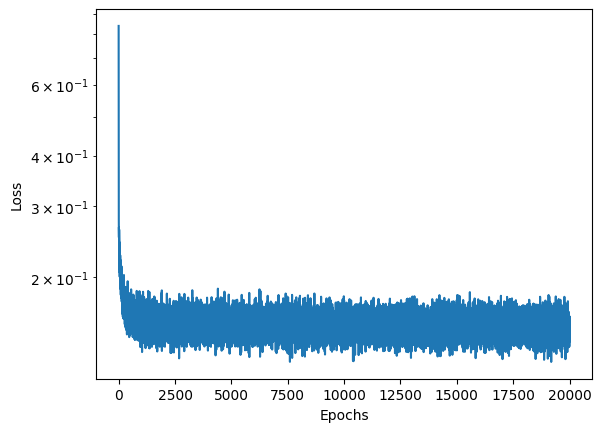

In [ ]:
"""
# OPTINAL: Check for normality across the batches
for batch in DDPM_CM.train_loader:
  q_dists, q_samples, x0 = DDPM_CM.diffuse(batch[0])
  DDPM_CM.check_normality(q_samples, alpha=0.05)

# train and save
DDPM_CM.loss_history = DDPM_CM.train(
    dataset = DDPM_CM.train_loader,
    epochs = 2*10**4,
)

plt.plot(DDPM_CM.loss_history)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()


DDPM_CM.save(os.path.join(save_dir, 'ddpm_cm.pth'), DDPM_CM.loss_history)
"""
# load
DDPM_CM, loaded_loss_hist = DDPM.load(os.path.join(save_dir, 'ddpm_cm.pth'), mean_model)
DDPM_CM.loss_history = loaded_loss_hist

plt.plot(DDPM_CM.loss_history)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

#Test data

In [ ]:
# create test datasets
testData1 = processed_data[processed_data['Date'].dt.year == 2020][['Date'] + Price_columns + ['LastUnit[Eur/MWh]'] + DDPM_CM.target_cols + DDPM_CM.label_cols + ['Season']]
labels = torch.tensor(DDPM_CM_databuilder.apply_normalization(testData1, DDPM_CM.label_cols)[DDPM_CM.label_cols].to_numpy(), dtype=torch.float32)

testData1_sample = DDPM_CM.generate_fake_data(labels, testData1)

# Compute price, specific to y_t prediction
for j, col in enumerate(Price_columns):
  testData1_sample[col] = testData1_sample[DDPM_CM.target_cols[j]]*testData1_sample['LastUnit[Eur/MWh]']

#Assesment

In [ ]:
# Create data assessment instance
DDPM_CM_DataAssessor = DataAssessor(
    'Season', testData1, testData1_sample, Price_columns, 'Price[Euros per MWh]', save_dir
    )

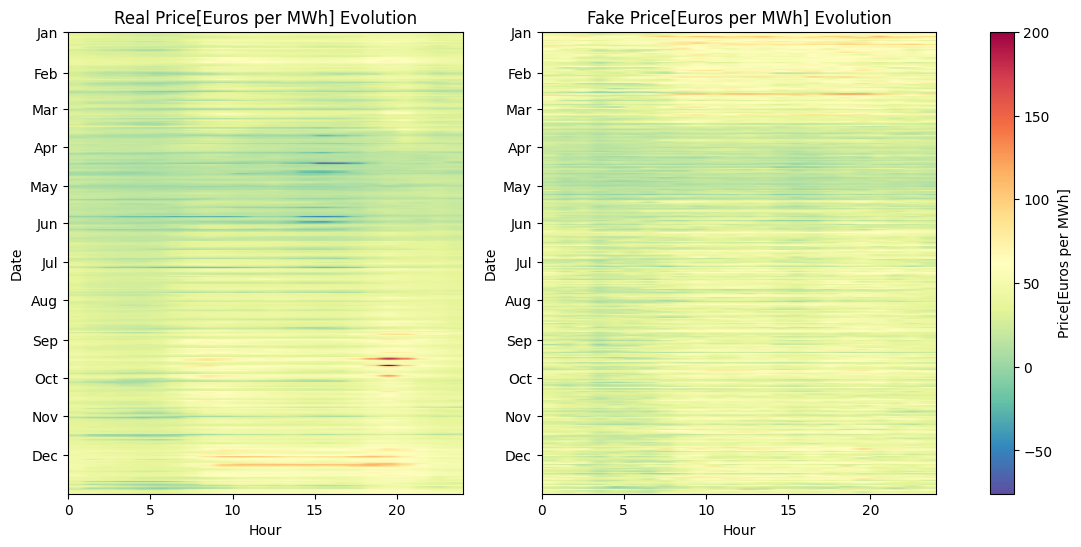

In [ ]:
# PLot evolutions real vs. fake
DDPM_CM_DataAssessor.plot_price_evolution()

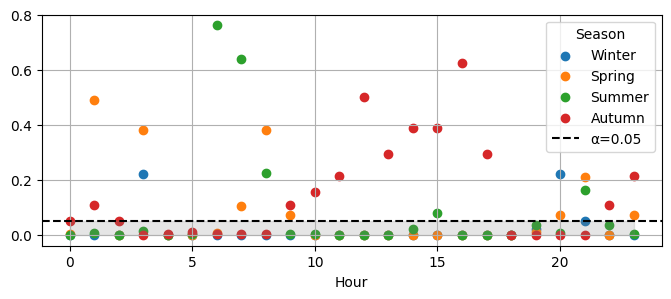

In [ ]:
DDPM_CM_DataAssessor.hour_wise_comparison_cycle()

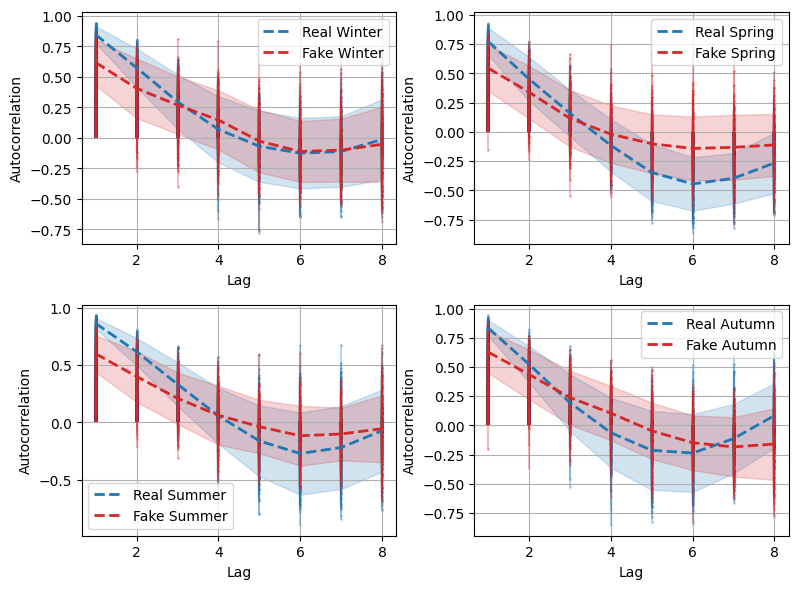

In [ ]:
DDPM_CM_DataAssessor.autocorr_by_cycle(lag_max=8)

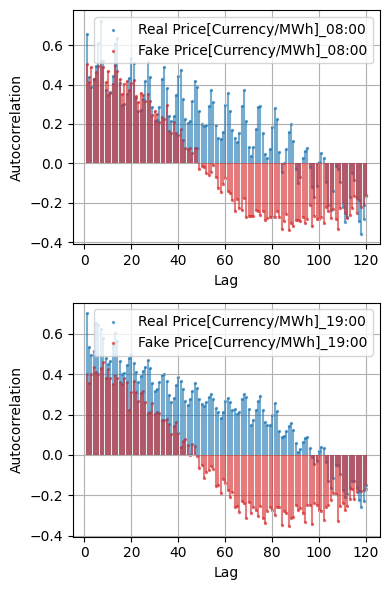

In [ ]:
DDPM_CM_DataAssessor.autocorr_by_hour(lag_max=120, compute_cols=[DDPM_CM_DataAssessor.target_cols[i] for i in [8,19]])

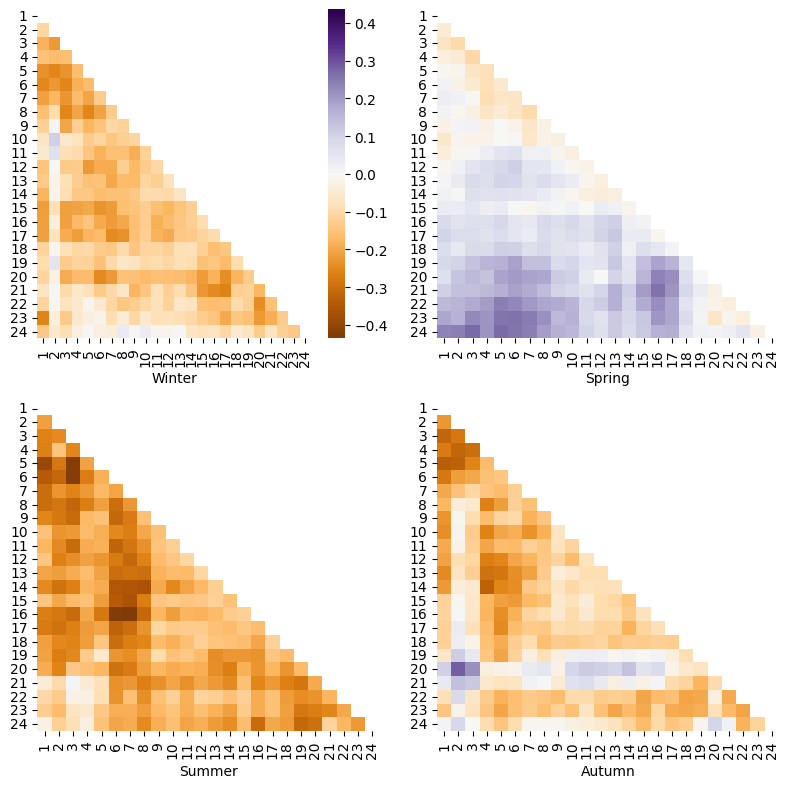

In [ ]:
DDPM_CM_DataAssessor.compute_correlation_matrices()
DDPM_CM_DataAssessor.plot_correlation_matrix_difference()

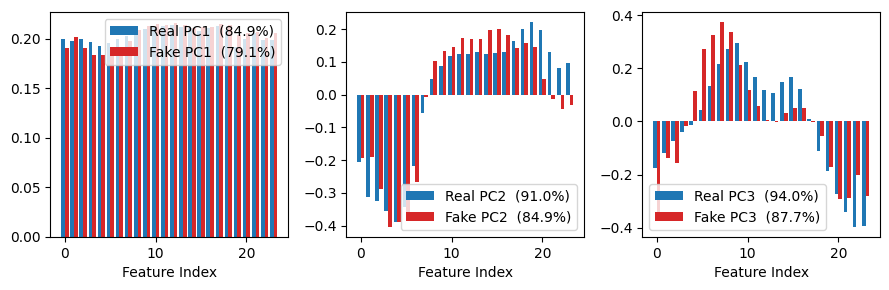

In [ ]:
DDPM_CM_DataAssessor.plot_principal_components(DDPM_CM_DataAssessor.principal_components(n_components=3, group_by = None), n_components=3, group_by = None)

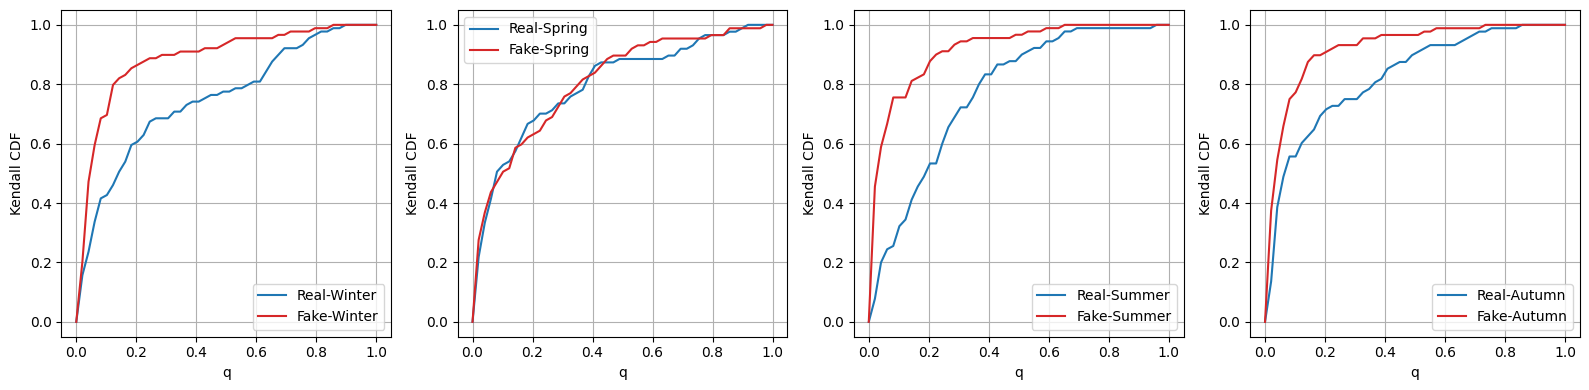

In [ ]:
DDPM_CM_DataAssessor.plot_kendall_dependence(DDPM_CM_DataAssessor.kendall_dependence(group_by = 'cycle'), group_by = 'cycle')

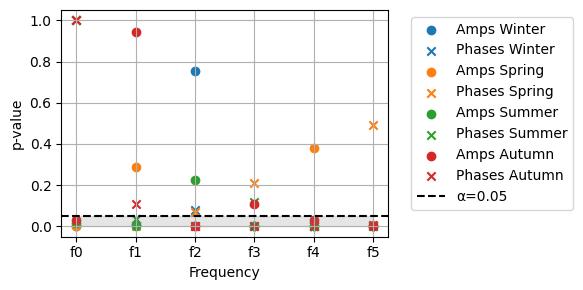

In [ ]:
DDPM_CM_DataAssessor.append_fft_features(k=5)
DDPM_CM_DataAssessor.plot_fft_comparison_by_cycle(k=5)

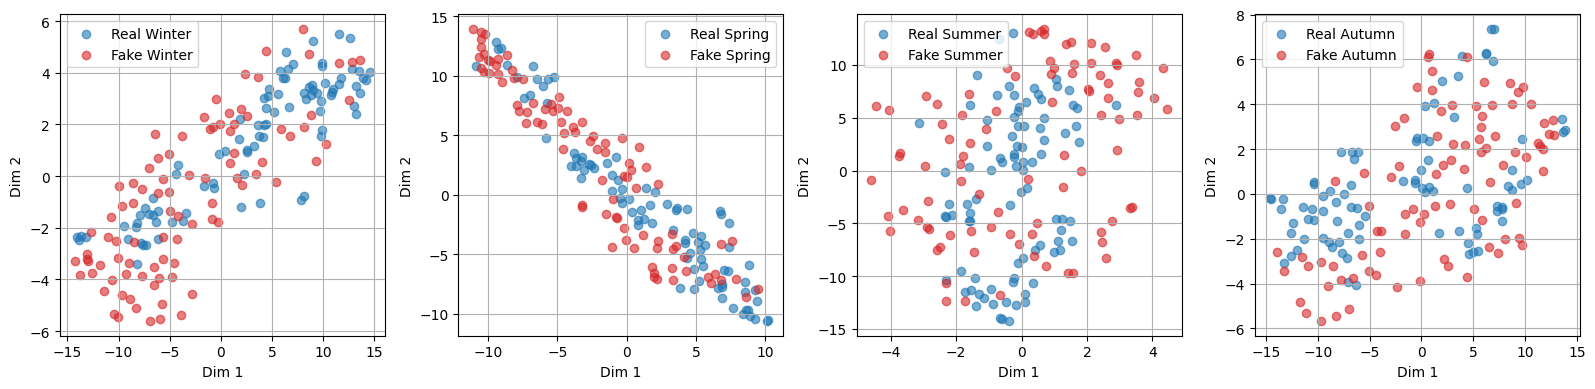

In [ ]:
DDPM_CM_DataAssessor.plot_tsne()

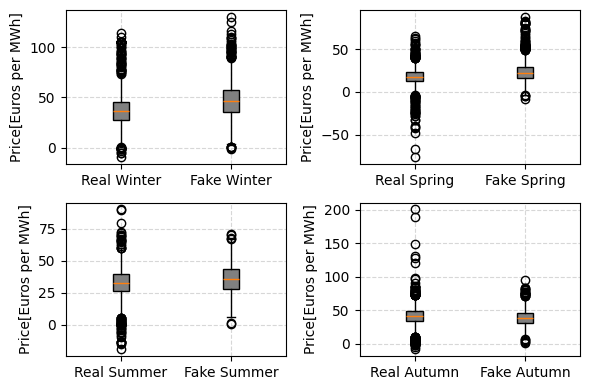

In [ ]:
DDPM_CM_DataAssessor.plot_extreme_boxplots()

#Battery

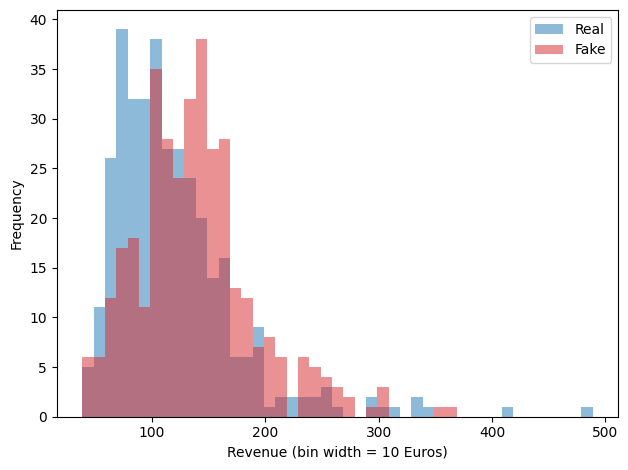

In [ ]:
DDPM_CM_DataAssessor.real_data_OptBatteryStorage = DDPM_CM_DataAssessor.apply_storage_const_price(DDPM_CM_DataAssessor.real_data, DDPM_CM_DataAssessor.target_cols, env=Myenv)
DDPM_CM_DataAssessor.fake_data_OptBatteryStorage = DDPM_CM_DataAssessor.apply_storage_const_price(DDPM_CM_DataAssessor.fake_data, DDPM_CM_DataAssessor.target_cols, env=Myenv)

DDPM_CM_DataAssessor.histogram_revenue(DDPM_CM_DataAssessor.real_data_OptBatteryStorage,DDPM_CM_DataAssessor.fake_data_OptBatteryStorage)

#Day

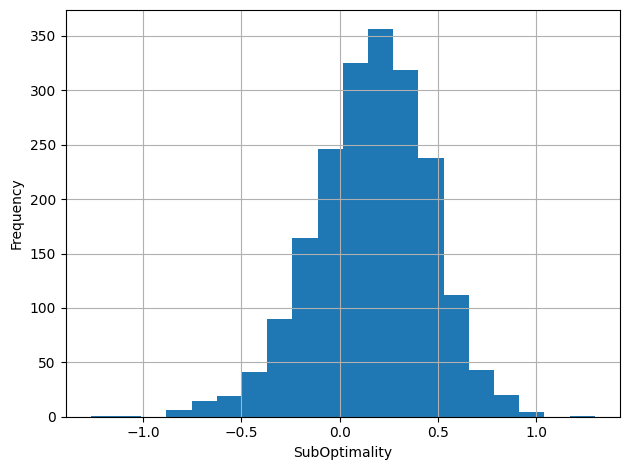

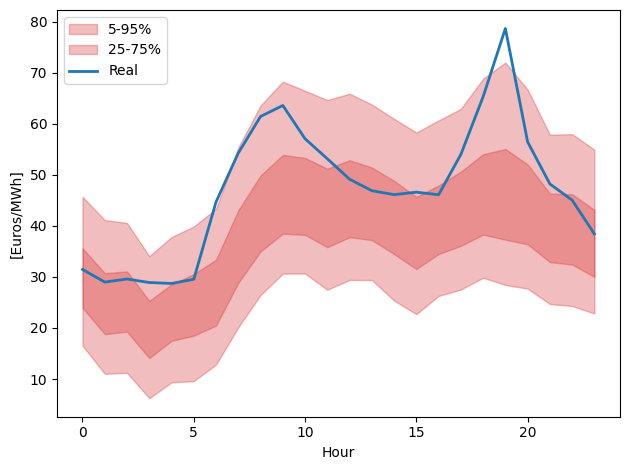

In [ ]:
_ = DDPM_CM_DataAssessor.replicate_compute_storage_suboptimality("2020-10-12", processed_data, 2000, DDPM_CM, DDPM_CM_databuilder, env=Myenv)
DDPM_CM_DataAssessor.prob_forecast("2020-10-12", processed_data, 2000, DDPM_CM, DDPM_CM_databuilder)

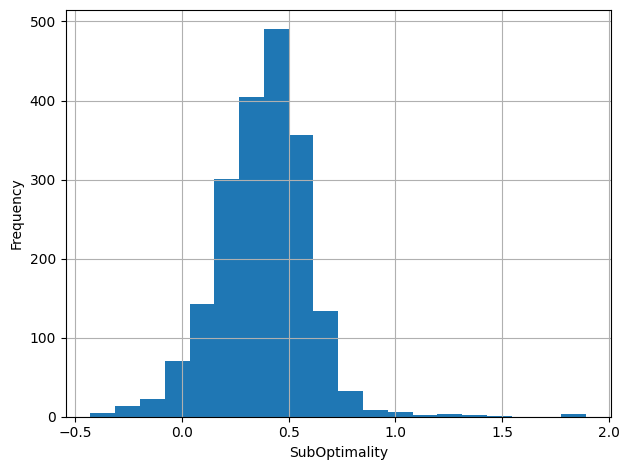

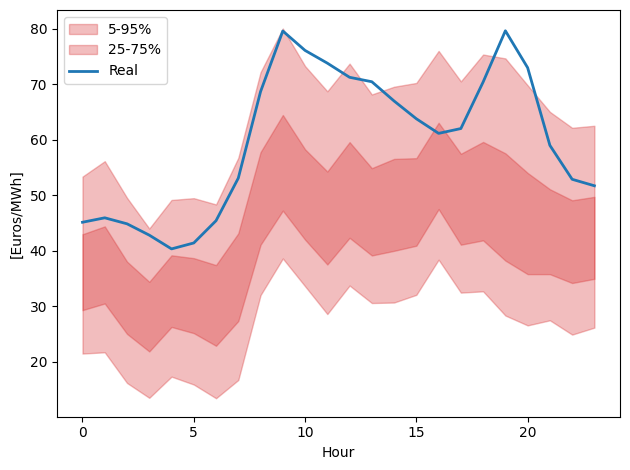

In [ ]:
_ = DDPM_CM_DataAssessor.replicate_compute_storage_suboptimality("2020-11-27", processed_data, 2000, DDPM_CM, DDPM_CM_databuilder, env=Myenv)
DDPM_CM_DataAssessor.prob_forecast("2020-11-27", processed_data, 2000, DDPM_CM, DDPM_CM_databuilder)

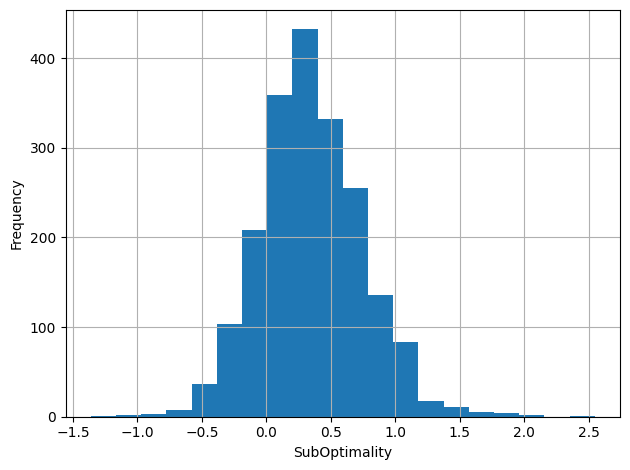

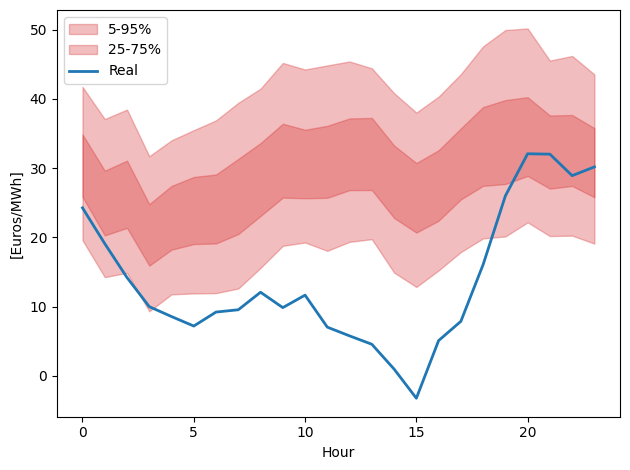

In [ ]:
_ = DDPM_CM_DataAssessor.replicate_compute_storage_suboptimality("2020-03-15", processed_data, 2000, DDPM_CM, DDPM_CM_databuilder, env=Myenv)
DDPM_CM_DataAssessor.prob_forecast("2020-03-15", processed_data, 2000, DDPM_CM, DDPM_CM_databuilder)

#2021

In [ ]:
# Create and process data
DataProcessor_2021 = DataProcessor(
    read_dir  = read_dir,
    date_col  = "Date",
    hour_cols = Hour_values,
    years_list=[2021, 2022]
)
#2021-09 to 2022-03
processed_data_2021 = DataProcessor_2021.process()
processed_data_2021 = processed_data_2021.loc[processed_data_2021['Date'].between(pd.Timestamp("2022-06-01"), pd.Timestamp("2022-12-31"))].copy()

In [ ]:
# create test datasets
testData_2021 = processed_data_2021[['Date'] + Price_columns + ['LastUnit[Eur/MWh]'] + DDPM_CM.target_cols + DDPM_CM.label_cols + ['Season']]
labels = torch.tensor(DDPM_CM_databuilder.apply_normalization(testData_2021, DDPM_CM.label_cols)[DDPM_CM.label_cols].to_numpy(), dtype=torch.float32)

testData_2021_sample = DDPM_CM.generate_fake_data(labels, testData_2021)

# Compute price, specific to y_t prediction
for j, col in enumerate(Price_columns):
  testData_2021_sample[col] = testData_2021_sample[DDPM_CM.target_cols[j]]*testData_2021_sample['LastUnit[Eur/MWh]']

In [ ]:
# Create data assessment instance
DDPM_CM_DataAssessor_2021 = DataAssessor(
    'Season', testData_2021, testData_2021_sample, Price_columns, 'Price[Euros per MWh]', save_dir
    )

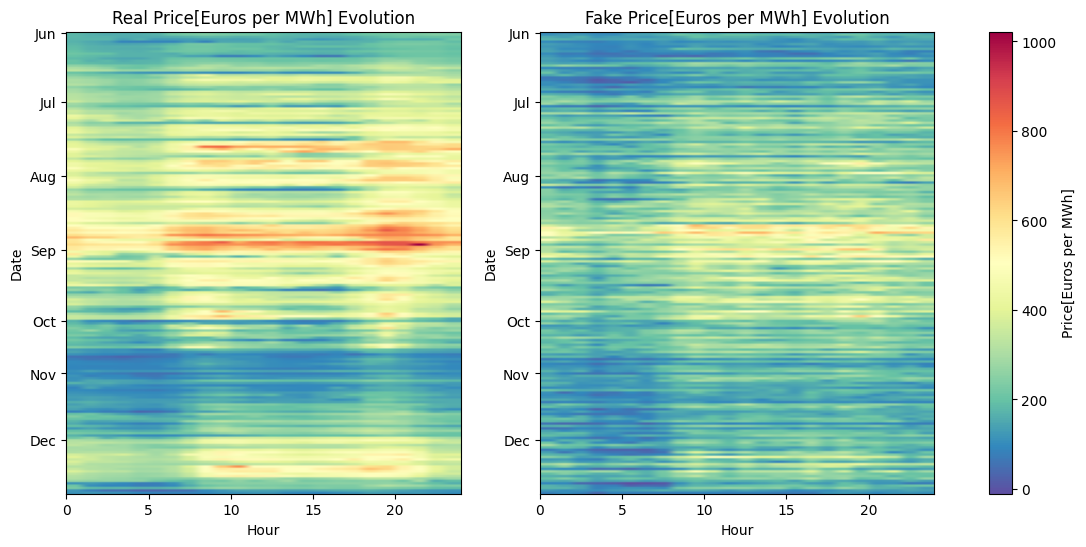

In [ ]:
# PLot evolutions real vs. fake
DDPM_CM_DataAssessor_2021.plot_price_evolution()

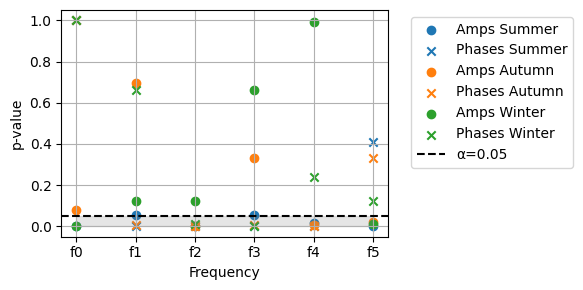

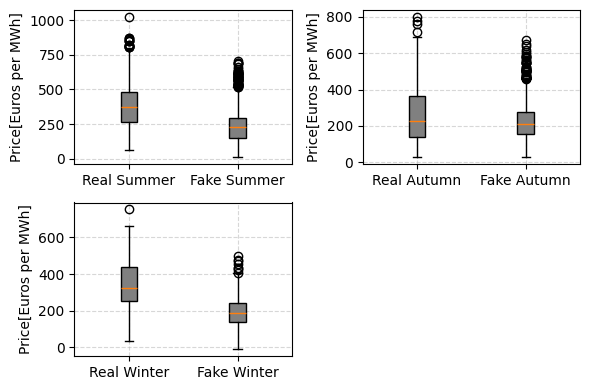

In [ ]:
DDPM_CM_DataAssessor_2021.append_fft_features(k=5)
DDPM_CM_DataAssessor_2021.plot_fft_comparison_by_cycle(k=5)


DDPM_CM_DataAssessor_2021.plot_extreme_boxplots()

#DDPM_CM_DD_PE

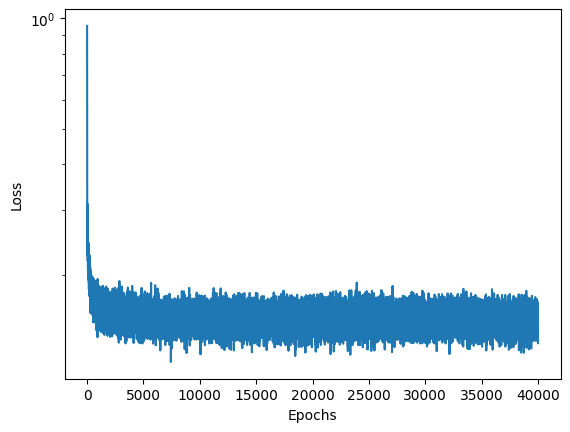

In [ ]:
save_dir = "/content/drive/My Drive/Colab Notebooks/A5_GANS/DPM/DPM_AidLike_CM_DD_PE"
os.makedirs(save_dir, exist_ok=True)

# Create DDPM instance selon target and label variables
DDPM_CM_DD_PE = DDPM(
    name         = "DDPM_CM_DD_PE",
    model_cls    = mean_model,
    target_cols  = y_t_columns,
    label_cols   = x_t_columns+DDemand_columns+exchanges_columns,
    t_label_cols = [],
    ab_t         = ab_t,
    a_t          = a_t,
    beta         = BETA_t,
)

# Create train set builder for the DDPM
DDPM_CM_DD_PE_databuilder = TrainingSetBuilder(
    df             = processed_data,
    gen_class           = DDPM_CM_DD_PE,
    random_state   = 42,
)

DDPM_CM_DD_PE.train_loader = DDPM_CM_DD_PE_databuilder.get_dataloader(
    batch_size = 64,
    shuffle    = True,
    normalize_target = False,
)
"""
# OPTINAL: Check for normality across the batches
for batch in DDPM_CM_DD_PE.train_loader:
  q_dists, q_samples, x0 = DDPM_CM_DD_PE.diffuse(batch[0])
  DDPM_CM_DD_PE.check_normality(q_samples, alpha=0.05)


# train and save
DDPM_CM_DD_PE.loss_history = DDPM_CM_DD_PE.train(
    dataset = DDPM_CM_DD_PE.train_loader,
    epochs = 4*10**4,
)

plt.plot(DDPM_CM_DD_PE.loss_history)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

DDPM_CM_DD_PE.save(os.path.join(save_dir, 'ddpm_cm_dd_pe.pth'), DDPM_CM_DD_PE.loss_history)
"""
# load
DDPM_CM_DD_PE, loaded_loss_hist = DDPM.load(os.path.join(save_dir, 'ddpm_cm_dd_pe.pth'), mean_model)
DDPM_CM_DD_PE.loss_history = loaded_loss_hist

plt.plot(DDPM_CM_DD_PE.loss_history)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

#Test data

In [ ]:
# create test datasets
testData1 = processed_data[processed_data['Date'].dt.year == 2020][['Date'] + Price_columns + ['LastUnit[Eur/MWh]'] + DDPM_CM_DD_PE.target_cols + DDPM_CM_DD_PE.label_cols + ['Season']]
labels = torch.tensor(DDPM_CM_DD_PE_databuilder.apply_normalization(testData1, DDPM_CM_DD_PE.label_cols)[DDPM_CM_DD_PE.label_cols].to_numpy(), dtype=torch.float32)

testData1_sample = DDPM_CM_DD_PE.generate_fake_data(labels, testData1)

# Compute price, specific to y_t prediction
for j, col in enumerate(Price_columns):
  testData1_sample[col] = testData1_sample[DDPM_CM_DD_PE.target_cols[j]]*testData1_sample['LastUnit[Eur/MWh]']

#Assessment

In [ ]:
# Create data assessment instance
DDPM_CM_DD_PE_DataAssessor = DataAssessor(
    'Season', testData1, testData1_sample, Price_columns, 'Price[Euros per MWh]', save_dir
    )

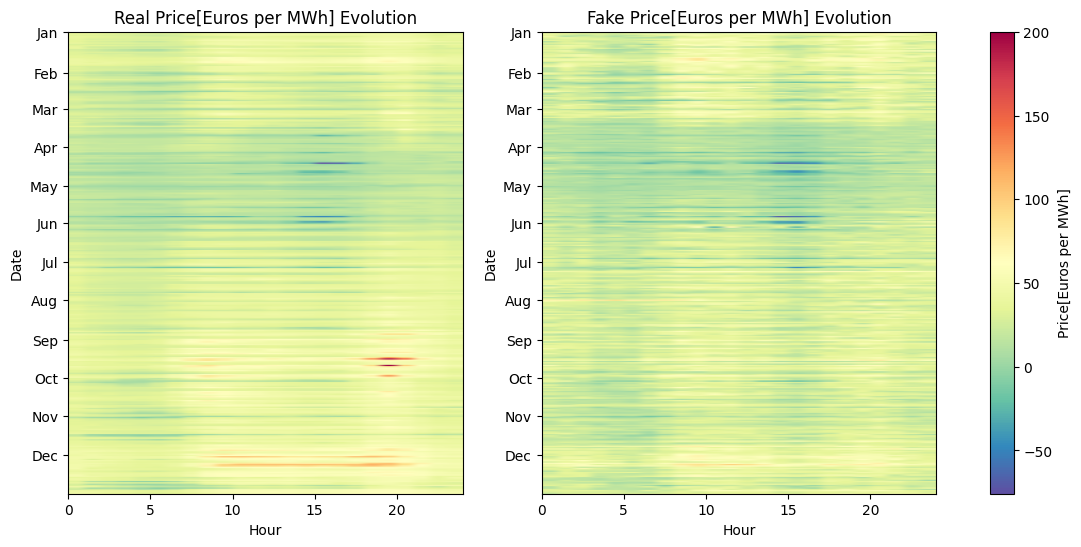

In [ ]:
# PLot evolutions real vs. fake
DDPM_CM_DD_PE_DataAssessor.plot_price_evolution()

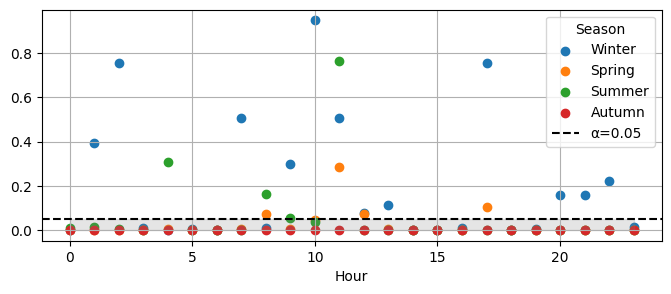

In [ ]:
DDPM_CM_DD_PE_DataAssessor.hour_wise_comparison_cycle()

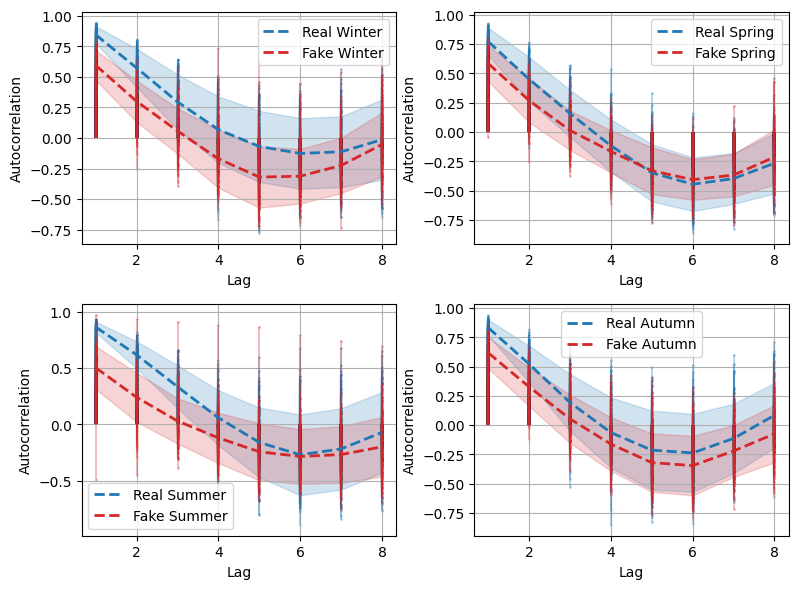

In [ ]:
DDPM_CM_DD_PE_DataAssessor.autocorr_by_cycle(lag_max=8)

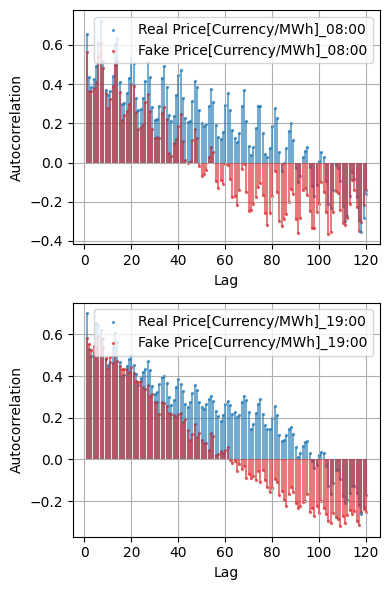

In [ ]:
DDPM_CM_DD_PE_DataAssessor.autocorr_by_hour(lag_max=120, compute_cols=[DDPM_CM_DD_PE_DataAssessor.target_cols[i] for i in [8,19]])

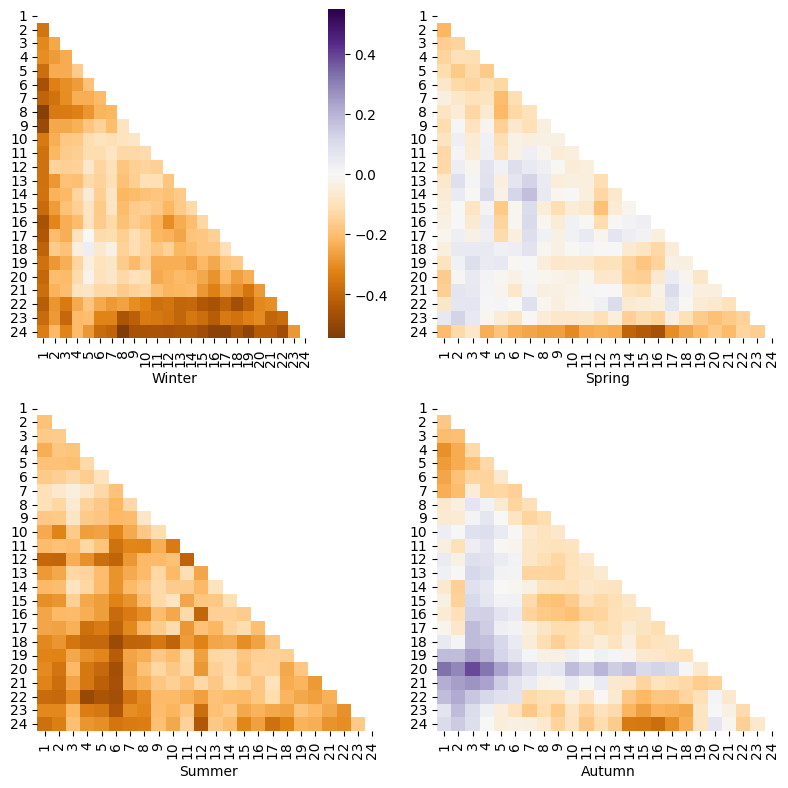

In [ ]:
DDPM_CM_DD_PE_DataAssessor.compute_correlation_matrices()
DDPM_CM_DD_PE_DataAssessor.plot_correlation_matrix_difference()

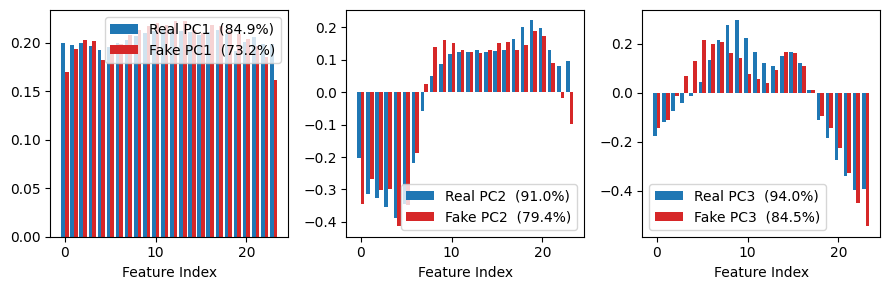

In [ ]:
DDPM_CM_DD_PE_DataAssessor.plot_principal_components(DDPM_CM_DD_PE_DataAssessor.principal_components(n_components=3, group_by = None), n_components=3, group_by = None)

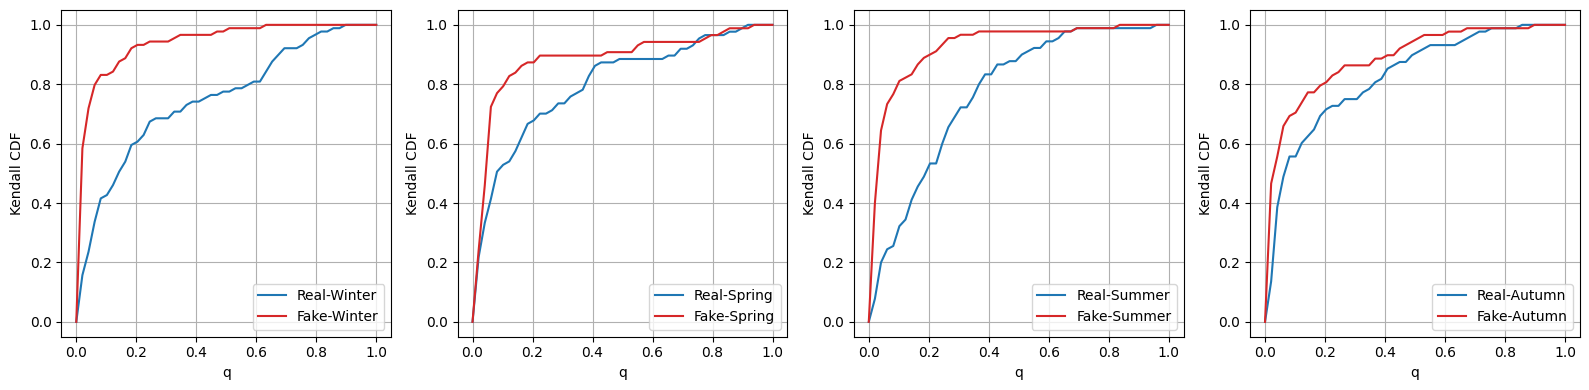

In [ ]:
DDPM_CM_DD_PE_DataAssessor.plot_kendall_dependence(DDPM_CM_DD_PE_DataAssessor.kendall_dependence(group_by = 'cycle'), group_by = 'cycle')

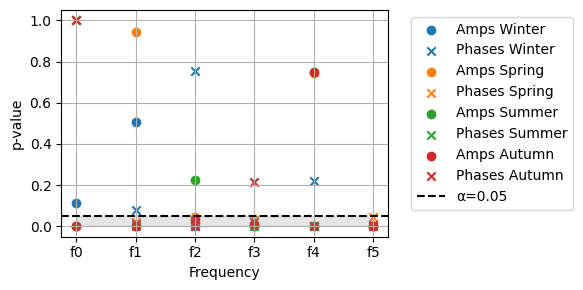

In [ ]:
DDPM_CM_DD_PE_DataAssessor.append_fft_features(k=5)
DDPM_CM_DD_PE_DataAssessor.plot_fft_comparison_by_cycle(k=5)

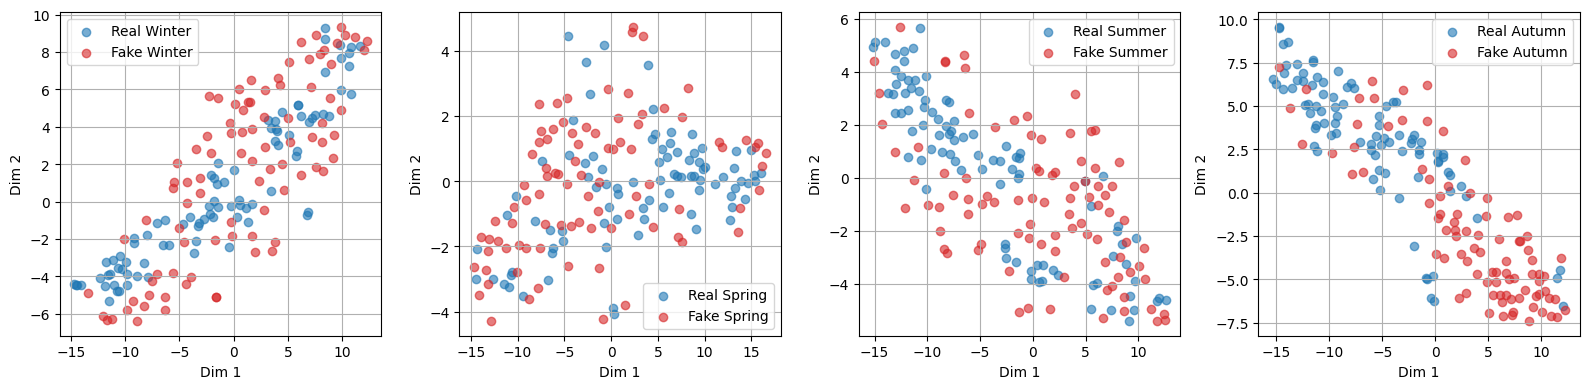

In [ ]:
DDPM_CM_DD_PE_DataAssessor.plot_tsne()

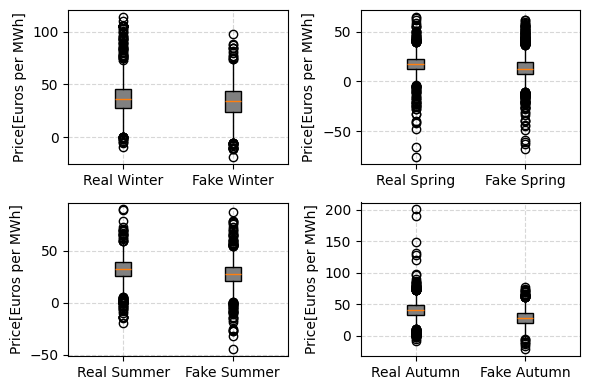

In [ ]:
DDPM_CM_DD_PE_DataAssessor.plot_extreme_boxplots()

#Battery

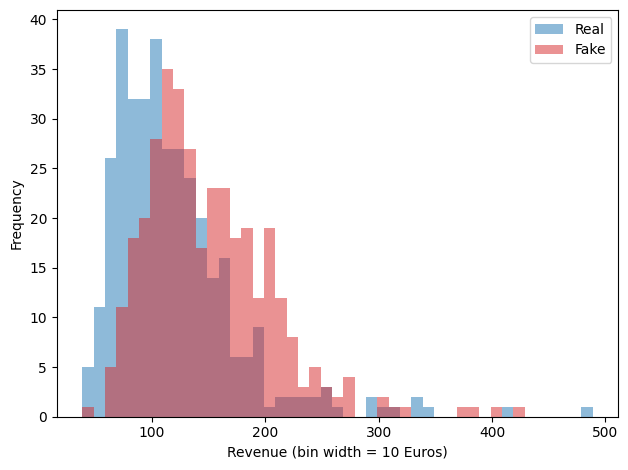

In [ ]:
DDPM_CM_DD_PE_DataAssessor.real_data_OptBatteryStorage = DDPM_CM_DD_PE_DataAssessor.apply_storage_const_price(DDPM_CM_DD_PE_DataAssessor.real_data, DDPM_CM_DD_PE_DataAssessor.target_cols, env=Myenv)
DDPM_CM_DD_PE_DataAssessor.fake_data_OptBatteryStorage = DDPM_CM_DD_PE_DataAssessor.apply_storage_const_price(DDPM_CM_DD_PE_DataAssessor.fake_data, DDPM_CM_DD_PE_DataAssessor.target_cols, env=Myenv)

DDPM_CM_DD_PE_DataAssessor.histogram_revenue(DDPM_CM_DD_PE_DataAssessor.real_data_OptBatteryStorage,DDPM_CM_DD_PE_DataAssessor.fake_data_OptBatteryStorage)

#Day

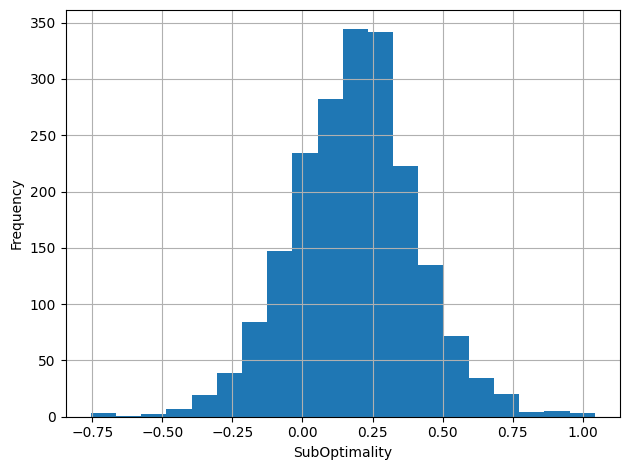

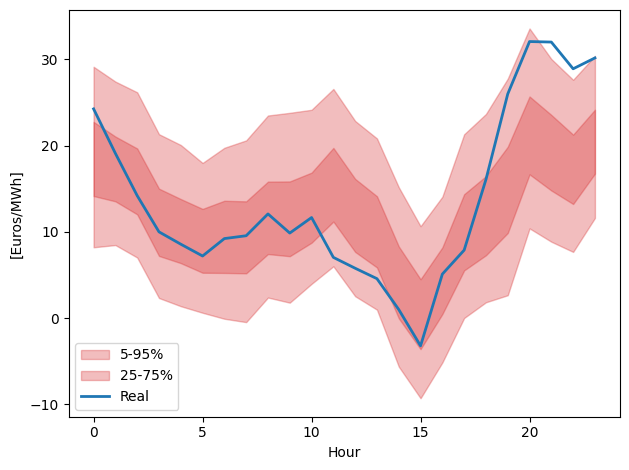

In [ ]:
_ = DDPM_CM_DD_PE_DataAssessor.replicate_compute_storage_suboptimality("2020-03-15", processed_data, 2000, DDPM_CM_DD_PE, DDPM_CM_DD_PE_databuilder, env=Myenv)
DDPM_CM_DD_PE_DataAssessor.prob_forecast("2020-03-15", processed_data, 2000, DDPM_CM_DD_PE, DDPM_CM_DD_PE_databuilder)

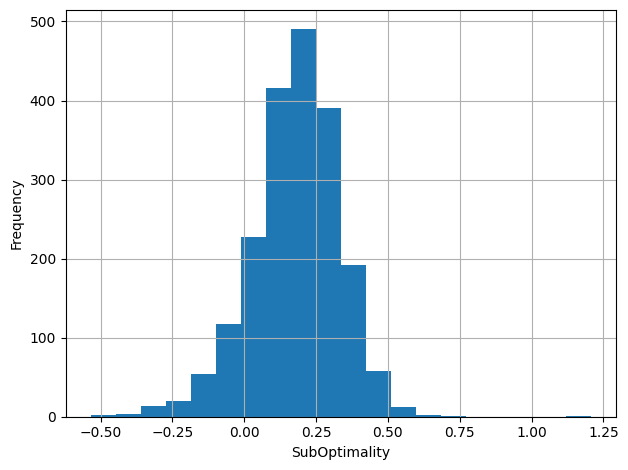

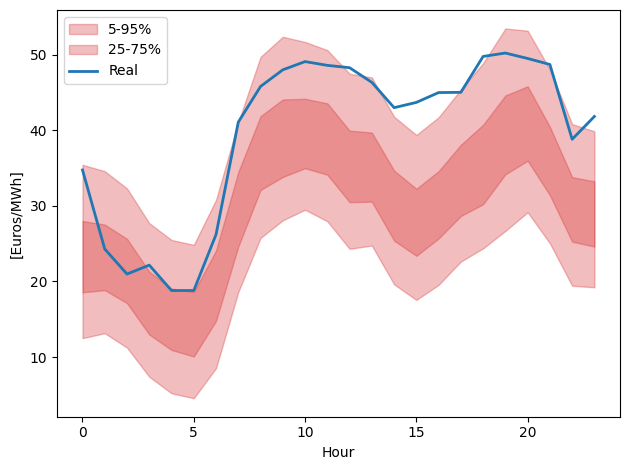

In [ ]:
_ = DDPM_CM_DD_PE_DataAssessor.replicate_compute_storage_suboptimality("2020-10-26", processed_data, 2000, DDPM_CM_DD_PE, DDPM_CM_DD_PE_databuilder, env=Myenv)
DDPM_CM_DD_PE_DataAssessor.prob_forecast("2020-10-26", processed_data, 2000, DDPM_CM_DD_PE, DDPM_CM_DD_PE_databuilder)

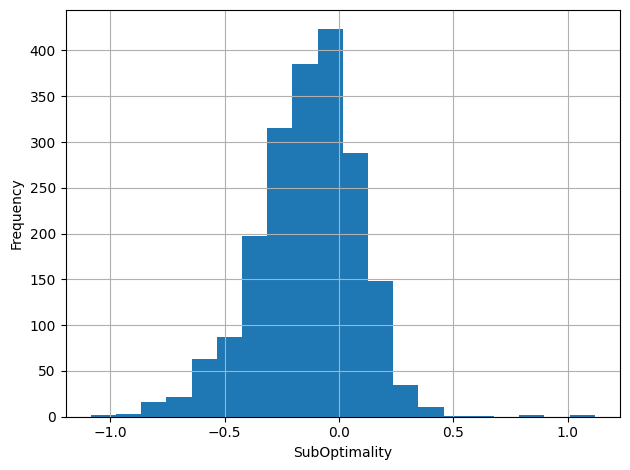

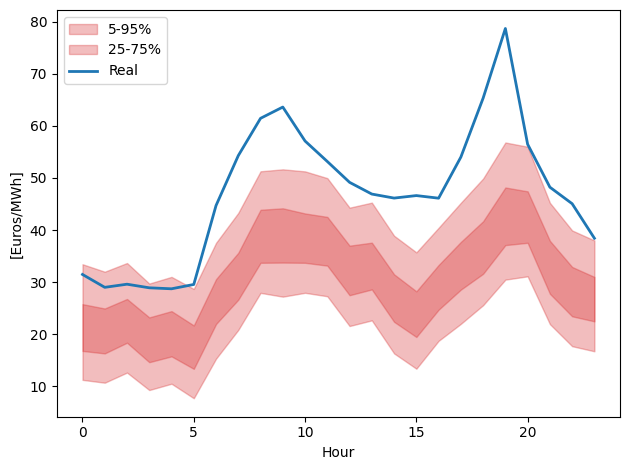

In [ ]:
_ = DDPM_CM_DD_PE_DataAssessor.replicate_compute_storage_suboptimality("2020-10-12", processed_data, 2000, DDPM_CM_DD_PE, DDPM_CM_DD_PE_databuilder, env=Myenv)
DDPM_CM_DD_PE_DataAssessor.prob_forecast("2020-10-12", processed_data, 2000, DDPM_CM_DD_PE, DDPM_CM_DD_PE_databuilder)

#2021

In [ ]:
# create test datasets
testData_2021 = processed_data_2021[['Date'] + Price_columns + ['LastUnit[Eur/MWh]'] + DDPM_CM_DD_PE.target_cols + DDPM_CM_DD_PE.label_cols + ['Season']]
labels = torch.tensor(DDPM_CM_DD_PE_databuilder.apply_normalization(testData_2021, DDPM_CM_DD_PE.label_cols)[DDPM_CM_DD_PE.label_cols].to_numpy(), dtype=torch.float32)

testData_2021_sample = DDPM_CM_DD_PE.generate_fake_data(labels, testData_2021)

# Compute price, specific to y_t prediction
for j, col in enumerate(Price_columns):
  testData_2021_sample[col] = testData_2021_sample[DDPM_CM_DD_PE.target_cols[j]]*testData_2021_sample['LastUnit[Eur/MWh]']

In [ ]:
# Create data assessment instance
DDPM_CM_DD_PE_DataAssessor_2021 = DataAssessor(
    'Season', testData_2021, testData_2021_sample, Price_columns, 'Price[Euros per MWh]', save_dir
    )

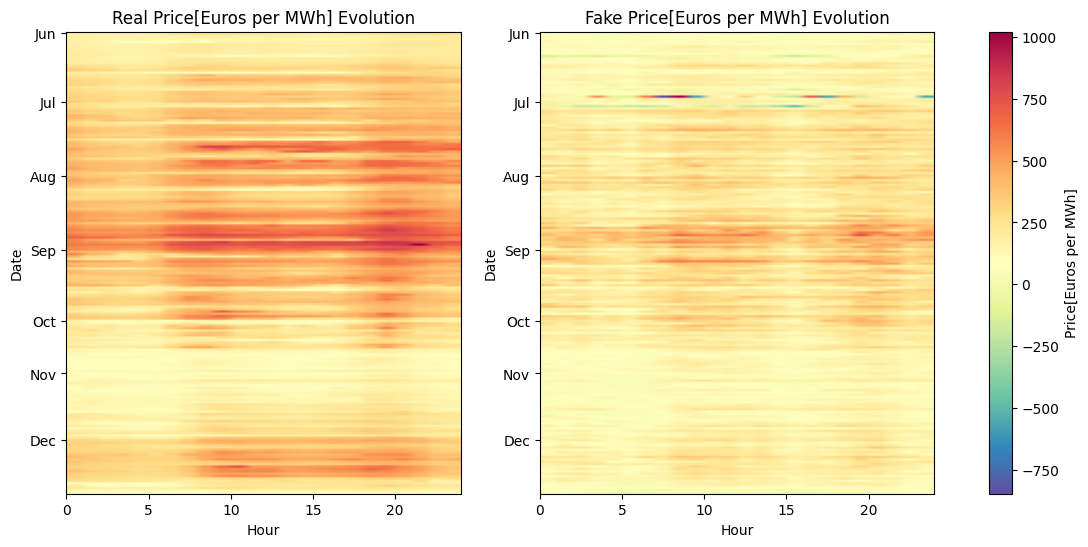

In [ ]:
# PLot evolutions real vs. fake
DDPM_CM_DD_PE_DataAssessor_2021.plot_price_evolution()

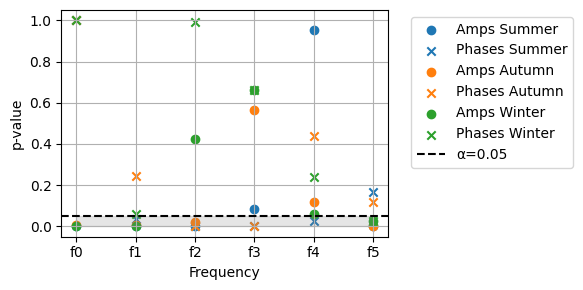

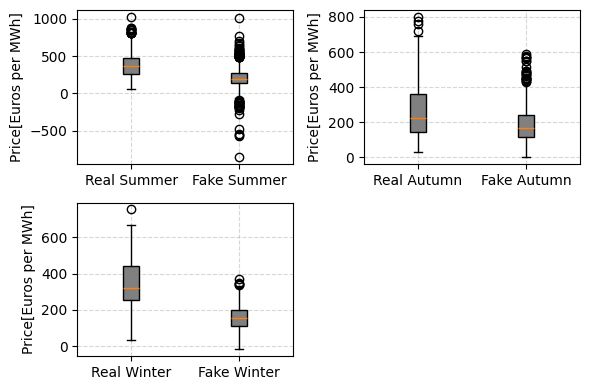

In [ ]:
DDPM_CM_DD_PE_DataAssessor_2021.append_fft_features(k=5)
DDPM_CM_DD_PE_DataAssessor_2021.plot_fft_comparison_by_cycle(k=5)


DDPM_CM_DD_PE_DataAssessor_2021.plot_extreme_boxplots()

#GANS

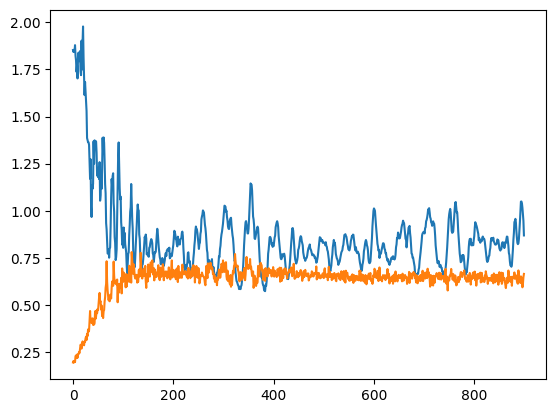

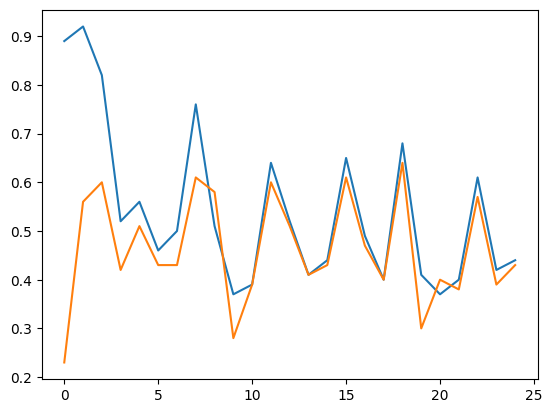

In [ ]:
GAN_CM = GAN(
    name          = "GAN_CM",
    latent_dim    = latent_dim,
    target_cols   = y_t_columns,
    label_cols    = x_t_columns,
    t_label_cols  = [],
    lr            = 2e-4,
)

# Create train set builder for the DDPM
GAN_CM_databuilder = TrainingSetBuilder(
    df             = processed_data,
    gen_class      = GAN_CM,
    random_state   = 42,
)

GAN_CM.train_loader = GAN_CM_databuilder.get_dataloader(
    batch_size = 64,
    shuffle    = True,
    normalize_target = False,
)

"""
GAN_CM.g_losses, GAN_CM.d_losses, GAN_CM.real_acc_list, GAN_CM.fake_acc_list = GAN_CM.train(
    Training_dataset_torch = torch.tensor(GAN_CM_databuilder.df_norm.values, dtype=torch.float32),
    Training_dataset_DataLoader = GAN_CM.train_loader,
    epochs = 50, n_feedback_every=2, n_feedback_samples=100)

GAN_CM.save('/content/drive/My Drive/Colab Notebooks/A5_GANS/GANS/GANS_AidLike_CM',
            GAN_CM.name+'_gen', GAN_CM.name+'_dis', GAN_CM.name+'_g_losses', GAN_CM.name+'_d_losses', GAN_CM.name+'_real_acc_list', GAN_CM.name+'_fake_acc_list',
            GAN_CM.g_losses, GAN_CM.d_losses, GAN_CM.real_acc_list, GAN_CM.fake_acc_list)

plt.plot(GAN_CM.g_losses, label='Generator')
plt.plot(GAN_CM.d_losses, label='Discriminator')
plt.show()

plt.plot(GAN_CM.real_acc_list, label='Real accuracy')
plt.plot(GAN_CM.fake_acc_list, label='Fake accuracy')
plt.show()
"""

# load
GAN_CM.generator, GAN_CM.discriminator, GAN_CM.g_losses, GAN_CM.d_losses, GAN_CM.real_acc_list, GAN_CM.fake_acc_list = GAN_CM.load(
    GAN_CM.name+'_gen', GAN_CM.name+'_dis', GAN_CM.name+'_g_losses', GAN_CM.name+'_d_losses', GAN_CM.name+'_real_acc_list', GAN_CM.name+'_fake_acc_list',
    '/content/drive/My Drive/Colab Notebooks/A5_GANS/GANS/GANS_AidLike_CM')

plt.plot(GAN_CM.g_losses, label='Generator')
plt.plot(GAN_CM.d_losses, label='Discriminator')
plt.show()

plt.plot(GAN_CM.real_acc_list, label='Real accuracy')
plt.plot(GAN_CM.fake_acc_list, label='Fake accuracy')
plt.show()

#Assessment

In [ ]:
# create test datasets
testData1 = processed_data[processed_data['Date'].dt.year == 2020][['Date'] + Price_columns + ['LastUnit[Eur/MWh]'] + GAN_CM.target_cols + GAN_CM.label_cols + ['Season']]
labels = torch.tensor(GAN_CM_databuilder.apply_normalization(testData1, GAN_CM.label_cols)[GAN_CM.label_cols].to_numpy(), dtype=torch.float32)

fake_data = GAN_CM.generate_fake_data(labels, testData1)

# Compute price, specific to y_t prediction
for j, col in enumerate(Price_columns):
  fake_data[col] = fake_data[GAN_CM.target_cols[j]]*fake_data['LastUnit[Eur/MWh]']

# Create data assessment instance
GAN_CM_DataAssessor = DataAssessor(
    'Season', testData1, fake_data, Price_columns, 'Price[Euros per MWh]',
    "/content/drive/My Drive/Colab Notebooks/A5_GANS/GANS/GANS_AidLike_CM")


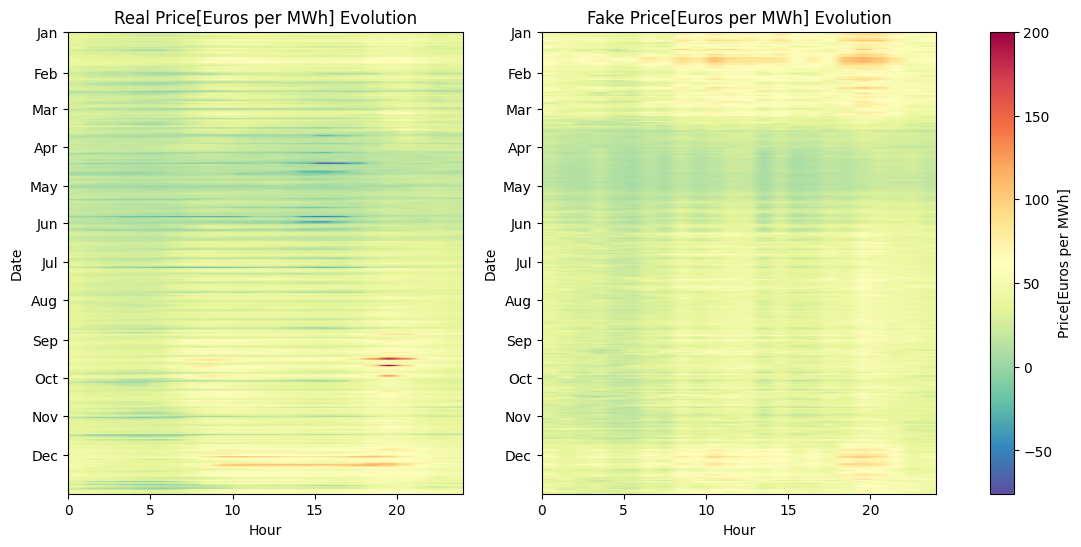

In [ ]:
# PLot evolutions real vs. fake
GAN_CM_DataAssessor.plot_price_evolution()

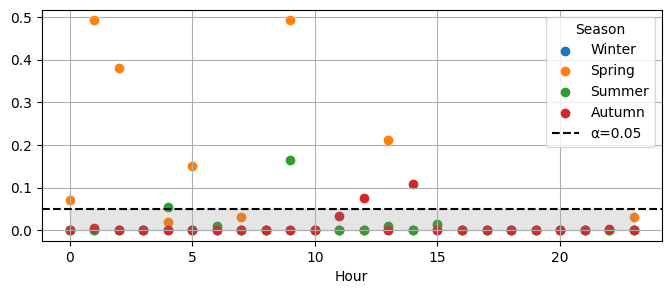

In [ ]:
GAN_CM_DataAssessor.hour_wise_comparison_cycle()

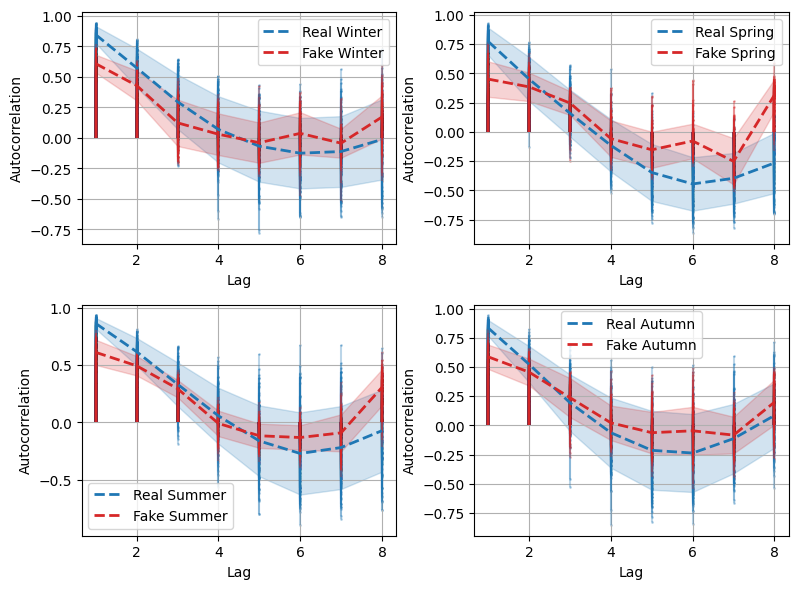

In [ ]:
GAN_CM_DataAssessor.autocorr_by_cycle(lag_max=8)

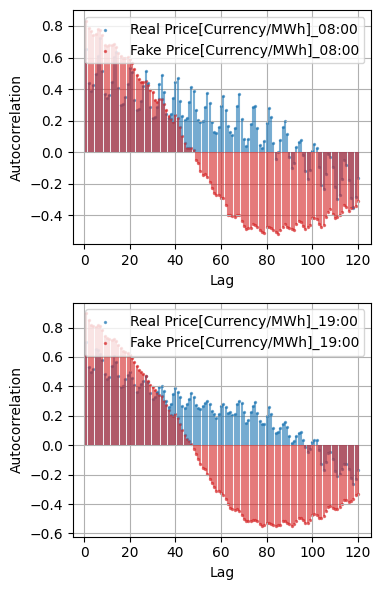

In [ ]:
GAN_CM_DataAssessor.autocorr_by_hour(lag_max=120, compute_cols=[GAN_CM_DataAssessor.target_cols[i] for i in [8,19]])

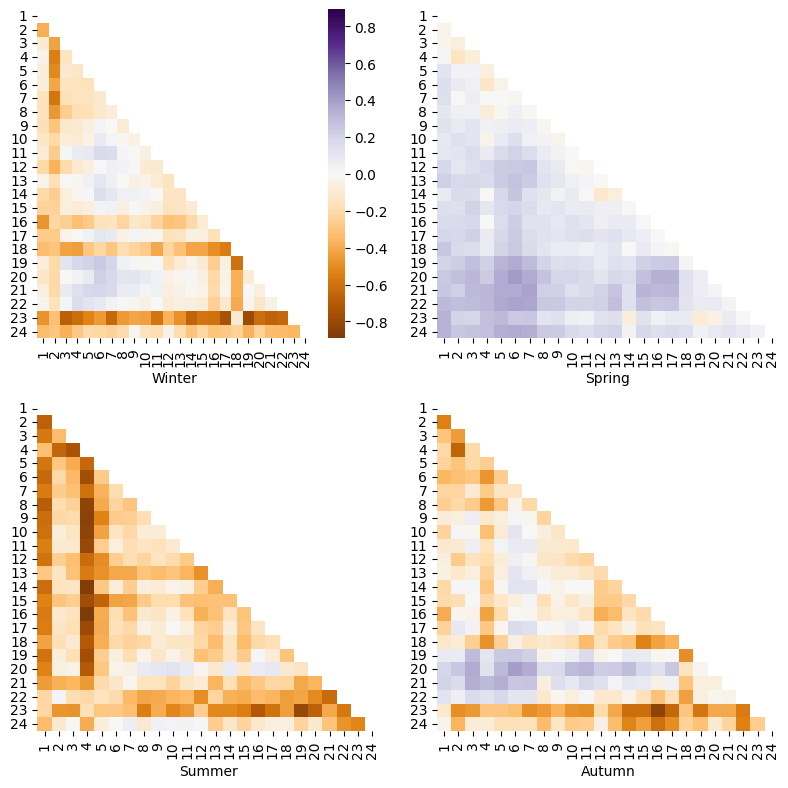

In [ ]:
GAN_CM_DataAssessor.compute_correlation_matrices()
GAN_CM_DataAssessor.plot_correlation_matrix_difference()

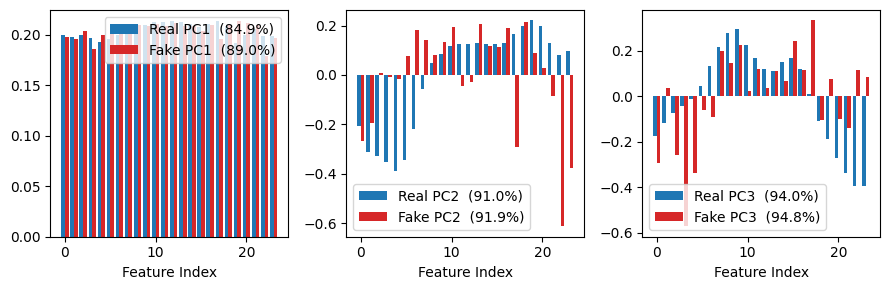

In [ ]:
GAN_CM_DataAssessor.plot_principal_components(GAN_CM_DataAssessor.principal_components(n_components=3, group_by = None), n_components=3, group_by = None)

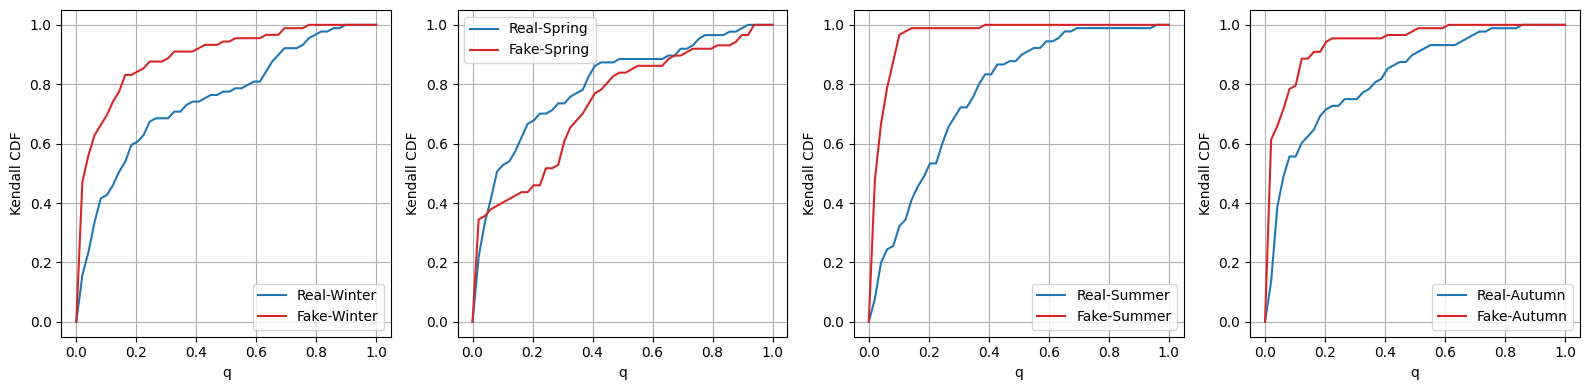

In [ ]:
GAN_CM_DataAssessor.plot_kendall_dependence(GAN_CM_DataAssessor.kendall_dependence(group_by = 'cycle'), group_by = 'cycle')

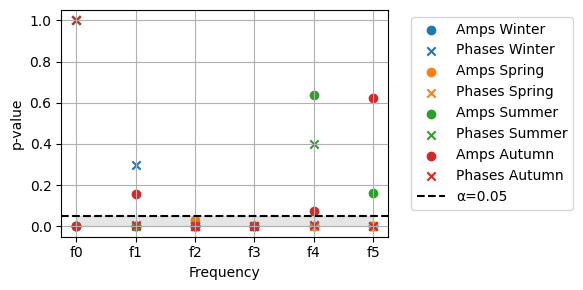

In [ ]:
GAN_CM_DataAssessor.append_fft_features(k=5)
GAN_CM_DataAssessor.plot_fft_comparison_by_cycle(k=5)

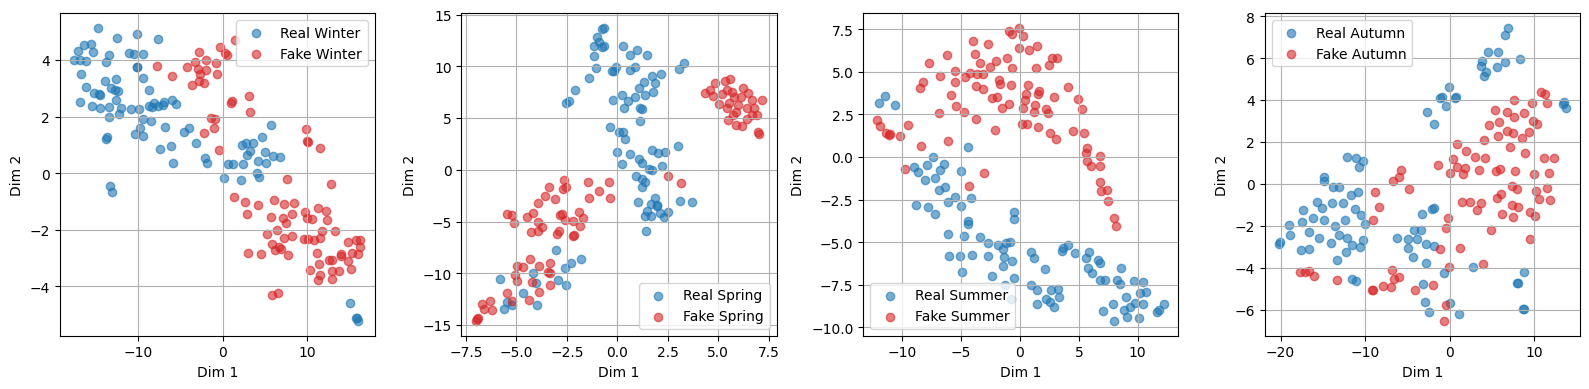

In [ ]:
GAN_CM_DataAssessor.plot_tsne()

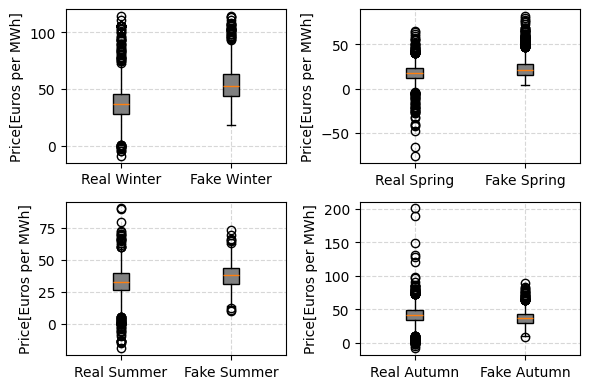

In [ ]:
GAN_CM_DataAssessor.plot_extreme_boxplots()

#Battery

In [ ]:
GAN_CM_DataAssessor.real_data_OptBatteryStorage = GAN_CM_DataAssessor.apply_storage_const_price(GAN_CM_DataAssessor.real_data, GAN_CM_DataAssessor.target_cols, env=Myenv)
GAN_CM_DataAssessor.fake_data_OptBatteryStorage = GAN_CM_DataAssessor.apply_storage_const_price(GAN_CM_DataAssessor.fake_data, GAN_CM_DataAssessor.target_cols, env=Myenv)

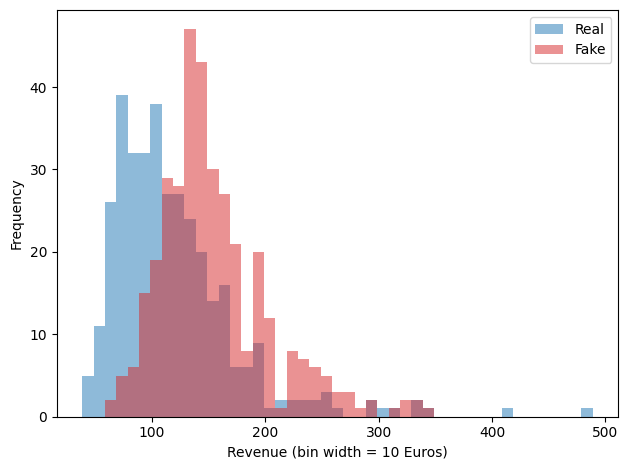

In [ ]:
GAN_CM_DataAssessor.histogram_revenue(GAN_CM_DataAssessor.real_data_OptBatteryStorage,GAN_CM_DataAssessor.fake_data_OptBatteryStorage)

#Day

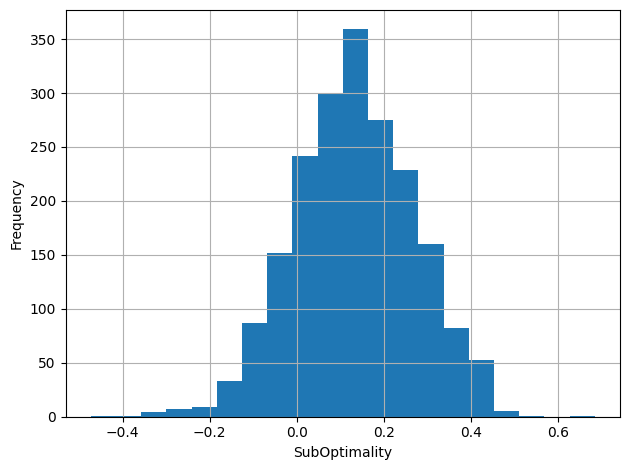

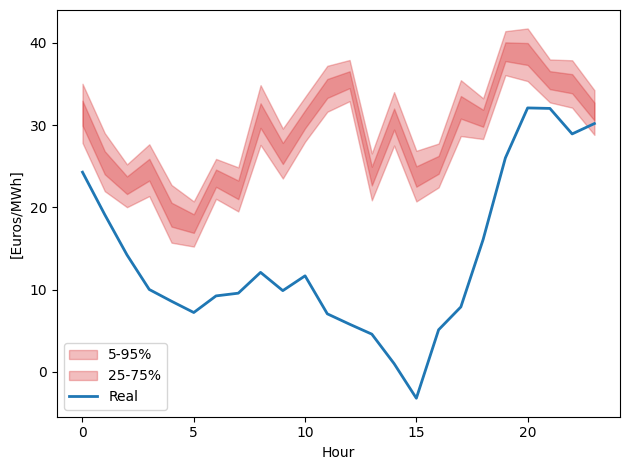

In [ ]:
_ = GAN_CM_DataAssessor.replicate_compute_storage_suboptimality("2020-03-15", processed_data, 2000, GAN_CM, GAN_CM_databuilder, env=Myenv)
GAN_CM_DataAssessor.prob_forecast("2020-03-15", processed_data, 2000, GAN_CM, GAN_CM_databuilder)

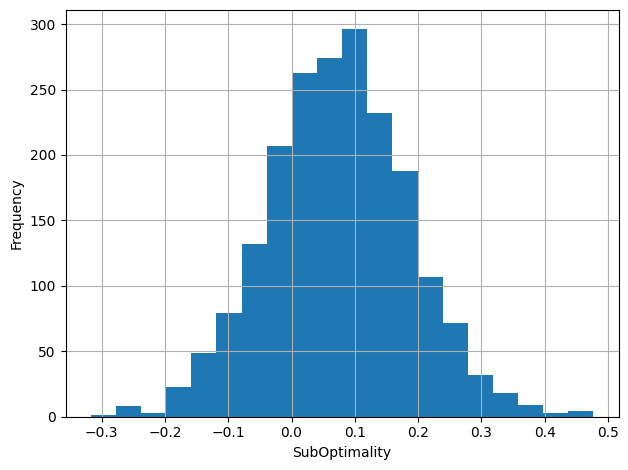

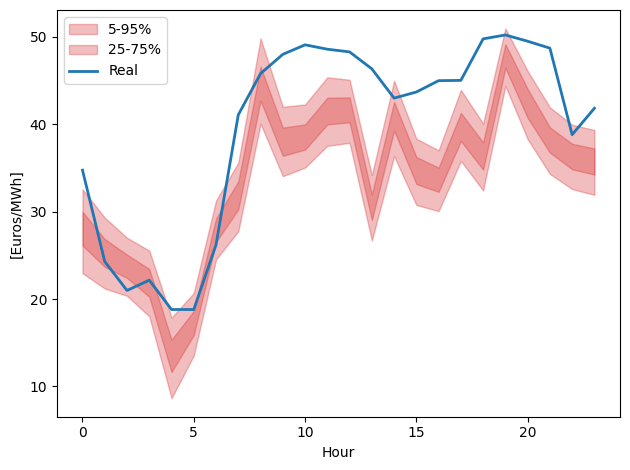

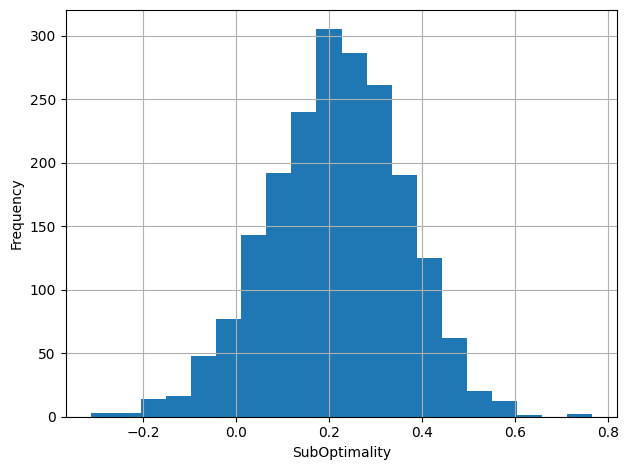

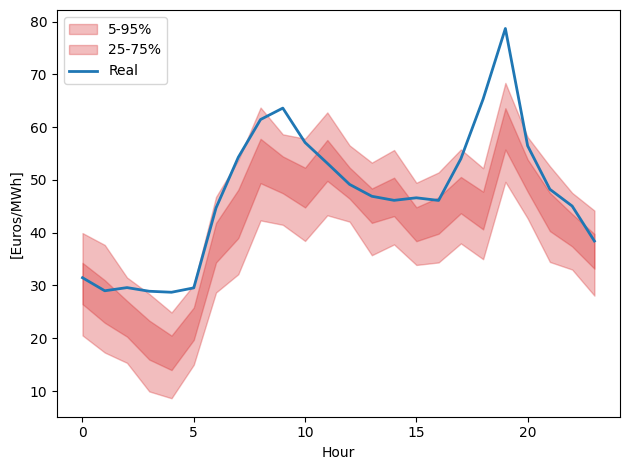

In [ ]:
_ = GAN_CM_DataAssessor.replicate_compute_storage_suboptimality("2020-10-26", processed_data, 2000, GAN_CM, GAN_CM_databuilder, env=Myenv)
GAN_CM_DataAssessor.prob_forecast("2020-10-26", processed_data, 2000, GAN_CM, GAN_CM_databuilder)

_ = GAN_CM_DataAssessor.replicate_compute_storage_suboptimality("2020-10-12", processed_data, 2000, GAN_CM, GAN_CM_databuilder, env=Myenv)
GAN_CM_DataAssessor.prob_forecast("2020-10-12", processed_data, 2000, GAN_CM, GAN_CM_databuilder)


#WGANs

In [ ]:
#Next WGAN and run :)